In [ ]:
import wandb
!wandb login # Enter your wandb API key here

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [2]:
%%writefile WordEmbeddings_Translate.py
import torch
import torch.nn as nn

class WordEmbeddings:
    def translateWordToTensor(self, word, vocabulary, language):
        '''
            Parameters:
                word : word on which to create the embeddings
                vocabulary : vocabulary of the dataset
                language : language of the dataset
            Returns :
                trans : embedding of the word
            Function:
                Generates the embeddings
        '''
        tensorList = list()
        if language == "english":
            tensorList.append(
                vocabulary.charToIndexDictForEnglish[vocabulary.startOfSequenceToken]
            )
        else:
            tensorList.append(
                vocabulary.charToIndexDictForBengali[vocabulary.startOfSequenceToken]
            )

        for one_char in word:
            if language == "english":
                tensorList.append(vocabulary.charToIndexDictForEnglish[one_char])
            else:
                tensorList.append(vocabulary.charToIndexDictForBengali[one_char])

        if language == "english":
            tensorList.append(
                vocabulary.charToIndexDictForEnglish[vocabulary.endOfSequenceToken]
            )
        else:
            tensorList.append(
                vocabulary.charToIndexDictForBengali[vocabulary.endOfSequenceToken]
            )

        trans = torch.tensor(tensorList, dtype=torch.int64)
        return trans

Writing WordEmbeddings_Translate.py


In [3]:
%%writefile WordEmbeddings_Create.py
import Utilities_Device_Trainings
import torch
import torch.nn as nn
from WordEmbeddings_Translate import WordEmbeddings as BaseWordEmbeddings

class WordEmbeddings(BaseWordEmbeddings):

    '''class to create the word embeddings'''
    def createWordEmbeddings(self, dataset, vocabulary):
        '''
            Parameters:
                dataset : dataset on which to create the embeddings
                vocabulary : vocabulary of the dataset
            Returns :
                None
            Function:
                Creates embeddings of the words
        '''
        englishDataset = dataset[:, 0]
        bengaliDataset = dataset[:, 1]

        tensorListEnglish = list()
        tensorListBengali = list()

        '''embeddings for source language'''
        language = "english"
        for one_word in englishDataset:
            tensor = self.translateWordToTensor(one_word, vocabulary, language)
            tensor = Utilities_Device_Trainings.setDevice(tensor)
            tensorListEnglish.append(tensor)
        self.englishEmbedding = nn.utils.rnn.pad_sequence(
            tensorListEnglish,
            padding_value=vocabulary.paddingIndex,
            batch_first=True
        )
        self.englishEmbedding = Utilities_Device_Trainings.setDevice(self.englishEmbedding)

        '''embeddings for target language'''
        language = "bengali"
        for one_word in bengaliDataset:
            tensor = self.translateWordToTensor(one_word, vocabulary, language)
            tensor = Utilities_Device_Trainings.setDevice(tensor)
            tensorListBengali.append(tensor)
        self.bengaliEmbedding = nn.utils.rnn.pad_sequence(
            tensorListBengali,
            padding_value=vocabulary.paddingIndex,
            batch_first=True
        )
        self.bengaliEmbedding = Utilities_Device_Trainings.setDevice(self.bengaliEmbedding)

Writing WordEmbeddings_Create.py


In [4]:
%%writefile EncoderArchitecture.py
import Utilities_Layer
import torch.nn as nn

'''class to represent the encoder architecture'''
class EncoderStack(nn.Module):

    '''constructor to intialize the class parameters'''
    def __init__(self, argList):
        '''inherit the constructor of the parent class'''
        super(EncoderStack, self).__init__()
        '''set all the class parameters based on the arguments passed'''
        modelType = argList[0]
        encoderInputSize = argList[1]
        embeddingSize = argList[2]
        neruonsInFC = argList[3]
        layersInEncoder = argList[4]
        dropout = argList[5]
        biDirectional = argList[6]
        attention = argList[7]

        self.neruonsInFC = neruonsInFC
        self.layersInEncoder = layersInEncoder
        if biDirectional == "YES":
            self.biDirect = True
        else:
            self.biDirect = False
        self.attention = attention

        '''select the cell type based on the value passed in argument'''
        model_dict = {"LSTM": nn.LSTM, "GRU": nn.GRU, "RNN": nn.RNN}
        modelObj = model_dict.get(modelType)

        '''do not apply dropout if only one layer is present'''
        if self.layersInEncoder == 1:
            self.dropout = Utilities_Layer.createDropoutLayer(0.0)
            self.model = modelObj(embeddingSize, self.neruonsInFC, self.layersInEncoder, dropout=0.0, bidirectional=self.biDirect)
        else:
            self.dropout = Utilities_Layer.createDropoutLayer(dropout)
            self.model = modelObj(embeddingSize, self.neruonsInFC, self.layersInEncoder, dropout=dropout, bidirectional=self.biDirect)

        '''create ambedding layer'''
        self.embeddingLayer = Utilities_Layer.createEmbeddingLayer(encoderInputSize, embeddingSize)

Writing EncoderArchitecture.py


In [5]:
%%writefile EncoderArchitecture_Forward.py
import Utilities_Tensor
import torch.nn as nn
from EncoderArchitecture import EncoderStack as BaseEncoderStack

'''class to add forward propagation to the encoder architecture'''
class EncoderStack(BaseEncoderStack):

    def forward(self, batchData):
        '''
            Parameters:
                batchData : data sent in batches (as a 2D tensor)
            Returns :
                modelEval : output from the current state of the encoder
                innerLayer : hidden layers representation
                model : the object of the combined architecture with updated parameters
            Function:
                Performs forward propagation in the architecture
        '''

        '''sets embedding layer'''
        embeddedBatch = self.embeddingLayer(batchData)
        embeddedBatch = self.dropout(embeddedBatch)
        model = None

        '''create the gates for LSTM'''
        if isinstance(self.model, nn.LSTM):
            modelEval, (innerLayer, model) = self.model(embeddedBatch)
            '''implement bidirectional architecture'''
            if self.biDirect:
                batchSize = model.size(1)
                model = Utilities_Tensor.resizeTensor(model, self.layersInEncoder, 2, batchSize, -1)
                model = Utilities_Tensor.reverseTensor(model)
                model = Utilities_Tensor.getMean(model)
            else:
                model = model[-1, :, :]
            model = Utilities_Tensor.increaseDimension(model)
        else:
            modelEval, innerLayer = self.model(embeddedBatch)

        '''check and implement bidirectional architecture'''
        if self.biDirect:
            batchSize = innerLayer.size(1)
            innerLayer = Utilities_Tensor.resizeTensor(innerLayer, self.layersInEncoder, 2, batchSize, -1)
            innerLayer = Utilities_Tensor.reverseTensor(innerLayer)
            innerLayer = Utilities_Tensor.getMean(innerLayer)
            '''apply attention'''
            if self.attention == 1:
                modelEval = Utilities_Tensor.addTensor(modelEval[:, :, :self.neruonsInFC], modelEval[:, :, self.neruonsInFC:])
        else:
            innerLayer = innerLayer[-1, :, :]

        innerLayer = Utilities_Tensor.increaseDimension(innerLayer)

        return modelEval, innerLayer, model

Writing EncoderArchitecture_Forward.py


In [6]:
%%writefile DecoderArchitecture.py
import Utilities_Layer
import torch.nn as nn

'''class to represent the decoder architecture'''
class DecoderStack(nn.Module):

    '''constructor to intialize the class parameters'''
    def __init__(self, argList):
        '''inherit the constructor of the parent class'''
        super(DecoderStack, self).__init__()
        '''set all the class parameters based on the arguments passed'''
        modelType = argList[0]
        decoderInputSize = argList[1]
        embeddingSize = argList[2]
        neruonsInFC = argList[3]
        outputWordSize = argList[4]
        layersInDecoder = argList[5]
        dropout = argList[6]
        attention = argList[7]

        self.modelType = modelType
        self.layersInDecoder = layersInDecoder
        self.outputWordSize = outputWordSize
        self.attention = attention
        
        '''select the cell type based on the value passed in argument'''
        modelDict = {"LSTM": nn.LSTM, "GRU": nn.GRU, "RNN": nn.RNN}
        modelObj = modelDict.get(modelType)

        '''apply attention'''
        if self.attention == 0:
            '''do not apply dropout if only one layer is present'''
            if layersInDecoder == 1:
                self.dropout = Utilities_Layer.createDropoutLayer(0.0)
                self.model = modelObj(embeddingSize, neruonsInFC, layersInDecoder, dropout=0.0)
            else:
                self.dropout = Utilities_Layer.createDropoutLayer(dropout)
                self.model = modelObj(embeddingSize, neruonsInFC, layersInDecoder, dropout=dropout)
            self.fullyConnectedLayer = nn.Linear(neruonsInFC, outputWordSize)
        else:
            '''do not apply dropout if only one layer is present'''
            if layersInDecoder == 1:
                self.dropout = Utilities_Layer.createDropoutLayer(0.0)
                self.model = modelObj(embeddingSize + neruonsInFC, neruonsInFC, layersInDecoder, dropout=0.0)
            else:
                self.dropout = Utilities_Layer.createDropoutLayer(dropout)
                self.model = modelObj(embeddingSize + neruonsInFC, neruonsInFC, layersInDecoder, dropout=dropout)
            self.fullyConnectedLayer = nn.Linear(neruonsInFC * 2, outputWordSize)
        
        '''create ambedding and linear layer'''
        self.embeddingLayer = Utilities_Layer.createEmbeddingLayer(decoderInputSize, embeddingSize)
        self.neuronsInAttentionFC = Utilities_Layer.createLinearLayer(neruonsInFC, neruonsInFC, False)

Writing DecoderArchitecture.py


In [7]:
%%writefile DecoderArchitecture_Forward.py
import Utilities_Tensor
import Utilities_Device_Trainings
import torch.nn as nn
from DecoderArchitecture import DecoderStack as BaseDecoderStack

'''class to add forward propagation to the decoder architecture'''
class DecoderStack(BaseDecoderStack):

    def forward(self, batchData, encoderOutput, innerLayer, model):
        '''
            Parameters:
                batchData : data sent in batches (as a 2D tensor)
                encoderOutput : output from the encoder (on which the decoder will work)
                innerLayer : hidden layers representation
                model : the object of the combined architecture on which the decoder is working
            Returns :
                predictions : predicted outputs from the decoder
                innerLayer : hidden layers representation
                model : the object of the combined architecture with updated parameters
                finalAttentionWeights : updated attention weights
            Function:
                Performs forward propagation in the architecture
        '''

        '''sets batch size and embedding layer'''
        batchData = Utilities_Tensor.increaseDimension(batchData)
        embeddedBatch = self.embeddingLayer(batchData)
        embeddingLayer = self.dropout(embeddedBatch)

        '''declare the attention matrix'''
        finalAttentionWeights = None

        '''appply attention and calculate the weights'''
        if self.attention == 1:
            finalOutputFromEncoderBlock = self.neuronsInAttentionFC(encoderOutput)
            finalHiddenLayer = innerLayer[-1:]
            attentionValues = Utilities_Tensor.mutiplyTensors(
                Utilities_Tensor.reorderDimensions(finalOutputFromEncoderBlock, 1, 0, 2),
                Utilities_Tensor.reorderDimensions(finalHiddenLayer, 1, 2, 0)
            )
            attentionValues = Utilities_Tensor.reorderDimensions(attentionValues, 2, 0, 1)
            finalAttentionWeights = Utilities_Device_Trainings.setOutputFunction(attentionValues)
            attentionIntoDecoder = Utilities_Tensor.mutiplyTensors(
                Utilities_Tensor.reorderDimensions(finalAttentionWeights, 1, 0, 2),
                Utilities_Tensor.reorderDimensions(encoderOutput, 1, 0, 2)
            )
            attentionIntoDecoder = Utilities_Tensor.reorderDimensions(attentionIntoDecoder, 1, 0, 2)

        '''check and apply attention'''
        if self.attention == 0:
            '''apply forget gate for LSTM'''
            if isinstance(self.model, nn.LSTM):
                modelEval, (innerLayer, model) = self.model(embeddingLayer, (innerLayer, model))
            else:
                modelEval, innerLayer = self.model(embeddingLayer, innerLayer)
            '''get decoder outputs by passing through the fully connected layer'''
            predictions = self.fullyConnectedLayer(modelEval)
        else:
            '''apply forget gate for LSTM'''
            concatenatedInput = Utilities_Tensor.concatenateTensor(embeddingLayer, attentionIntoDecoder, 2)
            if isinstance(self.model, nn.LSTM):
                modelEval, (innerLayer, model) = self.model(concatenatedInput, (innerLayer, model))
            else:
                modelEval, innerLayer = self.model(concatenatedInput, innerLayer)
            concatenatedInput = Utilities_Tensor.concatenateTensor(modelEval, attentionIntoDecoder, 2)
            '''get decoder outputs by passing through the fully connected layer'''
            predictions = self.fullyConnectedLayer(concatenatedInput)

        predictions = Utilities_Tensor.decreaseDimension(predictions)

        if self.attention == 1:
            finalAttentionWeights = Utilities_Tensor.decreaseDimension(finalAttentionWeights)

        return predictions, innerLayer, model, finalAttentionWeights

Writing DecoderArchitecture_Forward.py


In [8]:
%%writefile CombinedModelArchitecture_Utils.py
import Utilities_Tensor
import torch.nn as nn
import random

def formMatrix(dim1, dim2, dim3):
    '''
        Parameters:
            dim1 : First dimension of a tensor
            dim2 : Second dimension of the tensor
            dim3 : Third dimension of the tensor
        Returns :
            A tensor
        Function:
            Creates a tensor with all zeros following the dimensions passed as parameters
    '''
    return Utilities_Tensor.getZeroTensor(dim1, dim2, dim3)


def doTeacherForcing(decoderOutput, bengaliSequence, sequenceNumber, teacherRatio):
    '''
        Parameters:
            decoderOutput : Tensor representing the output of the previous state of the decoder
            bengaliSequence : Sequence of characters in the target language (bengali in this case)
            sequenceNumber : Index of the sequence to be considered
            teacherRatio : Threshold percentage on whether to apply teacher forching
        Returns :
            The function can return two things:
                if teacher forcing is not applied then return the output of the previous state of the decoder
                else return the actual target word
        Function:
            Performs teacher forcing in the decoder
    '''
    prediction = decoderOutput.argmax(dim=1)

    '''make a random guess and based on that decide whether or not to apply teacher forcing in the current timestamp'''
    currentGuess = random.random()
    if currentGuess < teacherRatio:
        return bengaliSequence[sequenceNumber]
    
    return prediction

Writing CombinedModelArchitecture_Utils.py


In [9]:
%%writefile CombinedModelArchitecture_Stack.py
import Utilities_Device_Trainings
import Utilities_Tensor
import torch.nn as nn
import random
from CombinedModelArchitecture_Utils import formMatrix, doTeacherForcing

'''class to represent the combined architecture of encoder and decoder'''
class EncoderDecoderStack(nn.Module):

    '''constructor to intialize the class parameters'''
    def __init__(self, argList):
        '''inherit the constructor of the parent class'''
        super(EncoderDecoderStack, self).__init__()
        '''encoder object'''
        self.encoderFramework = argList[0]
        '''decoder object'''
        self.decoderFramework = argList[1]
        '''attention(helps to decide whether to apply attention or not)'''
        self.attention = argList[2]
    

    def forward(self, englishSequence, bengaliSequence, teacherRatio=0.5):
        '''
            Parameters:
                englishSequence : Sequence of characters in the source language (english in this case)
                bengaliSequence : Sequence of characters in the target language (bengali in this case)
                teacherRatio : Threshold percentage on whether to apply teacher forching (set to 0.5 if not passed during function call)
            Returns :
                modelEval : output from the architecture
                attentions : updated attention weights
            Function:
                Performs forward propagation in the architecture
        '''

        '''sets batch size and maximum lengths of the words in the source and target dataset'''
        batchSize = Utilities_Tensor.getShapeOfTensor(englishSequence, 1)
        englishSequenceLength = Utilities_Tensor.getShapeOfTensor(englishSequence, 0)
        bengaliSequenceLength = Utilities_Tensor.getShapeOfTensor(bengaliSequence, 0)

        '''sets target vocabulary'''
        bengaliVocabulary = self.decoderFramework.outputWordSize

        '''forms the initial attention and output matrix'''
        attentions = formMatrix(bengaliSequenceLength, batchSize, englishSequenceLength)
        attentions = Utilities_Device_Trainings.setDevice(attentions)
        modelEval = formMatrix(bengaliSequenceLength, batchSize, bengaliVocabulary)
        modelEval = Utilities_Device_Trainings.setDevice(modelEval)

        '''passes the source word into the encoder'''
        encoderOutput, innerLayer, model = self.encoderFramework(englishSequence)

        '''resizes the tensor to match decoder architecture'''
        innerLayer = Utilities_Tensor.expandTensor(innerLayer, self.decoderFramework.layersInDecoder, 1, 1)
        
        '''resize the tensor if the cell is LSTM'''
        if isinstance(self.decoderFramework.model, nn.LSTM):
            model = Utilities_Tensor.expandTensor(model, self.decoderFramework.layersInDecoder, 1, 1)

        '''run the decoder based on whether attention is applied or not'''
        batchData = bengaliSequence[0]
        for sequenceNumber in range(1, bengaliSequenceLength):
            '''if no attention then no need to consider the attention weights being returned by decoder'''
            if self.attention == 0:
                decoderOutput, innerLayer, model, _ = self.decoderFramework(batchData, None, innerLayer, model)
            else:
                decoderOutput, innerLayer, model, attentionWeights = self.decoderFramework(batchData, encoderOutput, innerLayer, model)            
            modelEval[sequenceNumber] = decoderOutput

            '''if attention is applied then store the attention weights'''
            if self.attention == 1:
                attentions[sequenceNumber] = attentionWeights

            '''call teacher forcing function to implement it''' 
            batchData = doTeacherForcing(decoderOutput, bengaliSequence, sequenceNumber, teacherRatio)

        return modelEval, attentions

Writing CombinedModelArchitecture_Stack.py


In [10]:
%%writefile AccuracyAndLoss_Utils.py
import torch

def calculate(modelEval, outputSequence, paddingIndex, lossFunction):
    '''
        Parameters:
            modelEval : output from the model
            outputSequence : original word in the dataset
            paddingIndex : encoding of the padding characters in the vocabulary
            lossFunction : loss function used in the model
        Returns :
            modelEval : updated output to be used in the next batch of data
            correctPredictions : number of words predicted correctly
            totalLoss : loss generated by the current batch
        Function:
            Calculates number of correct predictions and loss for the data passed
    '''

    '''calculate correct predictions'''
    dim = modelEval.shape[2]
    predictedSequence = modelEval.argmax(dim=2)
    acuurate = (predictedSequence == outputSequence) + (outputSequence == paddingIndex)
    acuurate = torch.clamp(acuurate, max=1)
    acuurateAlongOneColumn = acuurate.all(dim=0)
    total = acuurateAlongOneColumn.sum()
    correctPredictions = total.item()

    '''calculate loss'''
    modelEvalSplit = modelEval[1:]
    modelEval = modelEvalSplit.reshape(-1, dim)
    bengaliSequenceSplit = outputSequence[1:]
    bengaliSequence = bengaliSequenceSplit.reshape(-1)
    loss = lossFunction(modelEval, bengaliSequence)
    totalLoss = loss.item()

    return modelEval, correctPredictions, totalLoss

Writing AccuracyAndLoss_Utils.py


In [11]:
%%writefile FindAccuracyAndLoss.py
import Utilities_Device_Trainings
import torch
from AccuracyAndLoss_Utils import calculate

'''class to find the accuracy and loss'''
class FindAccuracyAndLoss:
    def findAccuracyAndLoss(framework, dataLoader, batchSize, paddingIndex):
        '''
            Parameters:
                framework : object of the architecture
                dataLoader : data on which to calculate the accuracy and loss
                batchSize : batch size used
                paddingIndex : encoding of the padding characters in the vocabulary
            Returns :
                averageLoss : average loss across the dataset
                accuracy : accuracy of correct prediction 
            Function:
                Calculates the accuracy percentage and average loss for the dataset
        '''

        '''sets loss function'''
        framework.eval()
        lossFunction = Utilities_Device_Trainings.setLossFunction()
    
        totalLoss = 0.0
        correctPredictions = 0
        
        with torch.no_grad():
            '''iterate the whole dataset'''
            for _, data in enumerate(dataLoader):
                '''get the original source and target word'''
                inputSequence = data[0]
                outputSequence = data[1]
                inputSequence = inputSequence.T
                inputSequence = Utilities_Device_Trainings.setDevice(inputSequence)
                outputSequence = outputSequence.T
                outputSequence = Utilities_Device_Trainings.setDevice(outputSequence)

                '''run the encoder-decoder architecture with no teacher forcing (as we are in inference step)'''
                modelEval, _ = framework(inputSequence, outputSequence, teacherRatio=0.0)
                
                '''calculate the correct predictions and loss for the current batch of data'''
                modelEval, correctBatch, lossBatch = calculate(modelEval, outputSequence, paddingIndex, lossFunction)
                correctPredictions += correctBatch
                totalLoss += lossBatch
            
            '''avergae loss and accuracy percentage'''
            accuracy = correctPredictions / (len(dataLoader) * batchSize)
            averageLoss = totalLoss / len(dataLoader)
            return averageLoss, accuracy

Writing FindAccuracyAndLoss.py


In [12]:
%%writefile RunTrainer_Utils.py
import torch

def modification(modelEval, outputSequence):
    '''
        Parameters:
            modelEval : output from the model
            outputSequence : original target sequence
        Returns :
            modelEval : modified output to use it for other batches
            bengaliSequence : sequence in target language
        Function:
            Changes dimensions of the tensors
    '''
    dim = modelEval.shape[2]
    modelEvalSplit = modelEval[1:]
    modelEval = modelEvalSplit.reshape(-1, dim)
    bengaliSequenceSplit = outputSequence[1:]
    bengaliSequence = bengaliSequenceSplit.reshape(-1)
    return modelEval, bengaliSequence

Writing RunTrainer_Utils.py


In [13]:
%%writefile RunTrainer.py
import torch
from FindAccuracyAndLoss import FindAccuracyAndLoss
import Utilities_Device_Trainings
from torch.nn.utils import clip_grad_norm_
import wandb
from copy import deepcopy
from RunTrainer_Utils import modification

'''class to run the epochs on the model'''
class Trainer:

    def runModelTrainer(paramList, trainPy=0, saveBestModel=0, logging=1):
        '''
            Parameters:
                paramList : list of parameters passes
                trainPy : variable indicating whether to this is train.py call or not
                saveBestModel : variable indicating whether to save the model or not
            Returns :
                None
            Function:
                Drives the training process and run epochs
        '''

        '''set the parameters'''
        framework = paramList[0]
        learningRate = paramList[1]
        trainEmbeddedDataLoader = paramList[2]
        valEmbeddedDataLoader = paramList[3]
        epochs = paramList[4]
        batchSize = paramList[5]
        paddingIndex = paramList[6]

        '''declare lists for storing the accuracies and losses'''
        trainAccuracyPerEpoch = list()
        trainLossPerEpoch = list()
        valAccuracyPerEpoch = list()
        valLossPerEpoch = list()

        '''setting the optimizer'''
        backpropagationFramework = Utilities_Device_Trainings.setOptimizer(framework, learningRate)

        '''setting the loss function'''
        lossFunction = Utilities_Device_Trainings.setLossFunction()

        '''run epochs'''
        for epoch in range(epochs):
            framework.train()
            for id, data in enumerate(trainEmbeddedDataLoader):
                '''get the original source and target words'''
                inputSequence = data[0]
                outputSequence = data[1]
                inputSequence = inputSequence.T
                inputSequence = Utilities_Device_Trainings.setDevice(inputSequence)
                outputSequence = outputSequence.T
                outputSequence = Utilities_Device_Trainings.setDevice(outputSequence)

                '''run the encoder-decoder architecture'''
                modelEval, _ = framework(inputSequence, outputSequence)
                modelEval, bengaliSequence = modification(modelEval, outputSequence)

                '''run backpropagation'''
                backpropagationFramework.zero_grad()
                loss = lossFunction(modelEval, bengaliSequence)
                loss.backward()
                clip_grad_norm_(framework.parameters(), max_norm=1)
                backpropagationFramework.step()
            
            '''calculate the respective loss and accuracy'''
            trainingLoss, trainingAccuracy = FindAccuracyAndLoss.findAccuracyAndLoss(
                framework, trainEmbeddedDataLoader, batchSize, paddingIndex
            )
            valLoss, valAccuracy = FindAccuracyAndLoss.findAccuracyAndLoss(
                framework, valEmbeddedDataLoader, batchSize, paddingIndex
            )
            
            trainLossPerEpoch.append(trainingLoss)
            trainAccuracyPerEpoch.append(trainingAccuracy)
            valLossPerEpoch.append(valLoss)
            valAccuracyPerEpoch.append(valAccuracy)

            if logging == 1:
                '''print and log the losses and accuracies to terminal and wandb respectively'''
                print("\n===================================================================================================================")
                print(f"Epoch : {epoch+1}")
                print(f"Training Accuracy : {trainAccuracyPerEpoch[-1]}")
                print(f"Validation Accuracy : {valAccuracyPerEpoch[-1]}")
                print(f"Training Loss : {trainLossPerEpoch[-1]}")
                print(f"Validation Loss : {valLossPerEpoch[-1]}")  
                wandb.log({
                    "training_accuracy": trainAccuracyPerEpoch[-1],
                    "validation_accuracy": valAccuracyPerEpoch[-1],
                    "training_loss": trainLossPerEpoch[-1],
                    "validation_loss": valLossPerEpoch[-1],
                    "Epoch": epoch+1
                })
            else:
                if epoch == epochs - 1:
                    return framework

        '''save the model if needed'''
        if saveBestModel == 1:
            state = deepcopy(framework.state_dict())
            torch.save(state, "/frameworkState.pth")
        
        if trainPy == 1:
            return framework

Writing RunTrainer.py


In [ ]:
%%writefile LoadDataset_Train.py
import pandas as pd
import os

def loadDataset(self, root, lang):
    train_path = os.path.join(root, f"{lang}.translit.sampled.train.tsv")
    val_path   = os.path.join(root, f"{lang}.translit.sampled.dev.tsv")

    train_df = pd.read_csv(train_path, sep="\t", header=None, dtype=str)
    val_df = pd.read_csv(val_path, sep="\t", header=None, dtype=str)

    ''' Drop rows where either source or target is missing'''
    train_df = train_df.dropna(subset=[0, 1])
    val_df = val_df.dropna(subset=[0, 1])

    ''' Select only the first two columns'''
    self.train_dataset = train_df[[1, 0]].values  
    self.val_dataset = val_df[[1, 0]].values

Writing LoadDataset_Train.py


In [ ]:
%%writefile LoadDataset_Test.py
import pandas as pd
import os
from LoadDataset_Train import loadDataset

def loadTestDataset(self, root, lang):
    '''
        Parameters:
            root : path of the dataset
            lang : language which is chosen (taken from the path itself)
        Returns :
            None
        Function:
            Loads test dataset
    '''
    test_path = os.path.join(root, f"{lang}.translit.sampled.test.tsv")
    test_df = pd.read_csv(test_path, sep="\t", header=None, dtype=str)
    test_df = test_df.dropna(subset=[0, 1])
    self.test_dataframe = test_df               
    self.test_dataset = test_df[[1, 0]].values  
    

'''class to load dataset'''
class DatasetLoad:
    pass

'''attach methods to DatasetLoad '''
DatasetLoad.loadDataset = loadDataset
DatasetLoad.loadTestDataset = loadTestDataset

Writing LoadDataset_Test.py


In [16]:
%%writefile PrepareVocabulary_Initialize.py
'''initializes the vocabulary dictionaries'''
def initializeVocabularyDictionaries(self):
    '''
        Parameters:
            None
        Returns :
            None
        Function:
            Initializes the vocabulary dictionaries
    '''

    '''dictionary for source language'''
    self.charToIndexDictForEnglish[self.startOfSequenceToken]=self.startOfSequenceIndex
    self.charToIndexDictForEnglish[self.endOfSequenceToken]=self.endOfSequenceIndex
    self.charToIndexDictForEnglish[self.paddingToken]=self.paddingIndex

    self.indexToCharDictForEnglish[self.startOfSequenceIndex]=self.startOfSequenceToken
    self.indexToCharDictForEnglish[self.endOfSequenceIndex]=self.endOfSequenceToken
    self.indexToCharDictForEnglish[self.paddingIndex]=self.paddingToken

    '''dictionary for target language'''
    self.charToIndexDictForBengali[self.startOfSequenceToken]=self.startOfSequenceIndex
    self.charToIndexDictForBengali[self.endOfSequenceToken]=self.endOfSequenceIndex
    self.charToIndexDictForBengali[self.paddingToken]=self.paddingIndex

    self.indexToCharDictForBengali[self.startOfSequenceIndex]=self.startOfSequenceToken
    self.indexToCharDictForBengali[self.endOfSequenceIndex]=self.endOfSequenceToken
    self.indexToCharDictForBengali[self.paddingIndex]=self.paddingToken

Writing PrepareVocabulary_Initialize.py


In [17]:
%%writefile PrepareVocabulary_Create.py
'''creates vocabulary of each word in the dataset'''
def createVocabulary(self, dataset):
    '''
        Parameters:
            dataset : dataset on which to create the vocabulary
        Returns :
            None
        Function:
            creates vocabulary of each word in the dataset
    '''

    '''iterate over the entire dataset'''
    for each_pair in dataset:
        english_word=each_pair[0]
        bengali_word=each_pair[1]

        '''create vocabulary for the source language'''
        for one_char in english_word:
            '''if the character is not already recorded then add it to the dictionary'''
            if one_char not in self.charToIndexDictForEnglish:
                self.charToIndexDictForEnglish[one_char]=self.vocabularySizeForEnglish
                self.charCounterForEnglish[one_char]=1
                self.indexToCharDictForEnglish[self.vocabularySizeForEnglish]=one_char
                self.vocabularySizeForEnglish+=1
            else:
                self.charCounterForEnglish[one_char]+=1
        
        '''create vocabulary for the target language'''
        for one_char in bengali_word:
            '''if the character is not already recorded then add it to the dictionary'''
            if one_char not in self.charToIndexDictForBengali:
                self.charToIndexDictForBengali[one_char]=self.vocabularySizeForBengali
                self.charCounterForBengali[one_char]=1
                self.indexToCharDictForBengali[self.vocabularySizeForBengali]=one_char
                self.vocabularySizeForBengali+=1
            else:
                self.charCounterForBengali[one_char]+=1

Writing PrepareVocabulary_Create.py


In [18]:
%%writefile PrepareVocabulary_Final.py
from PrepareVocabulary_Initialize import initializeVocabularyDictionaries
from PrepareVocabulary_Create import createVocabulary

'''class to prepare the vocabulary of the dataset'''
class PrepareVocabulary:

    '''constructor to intialize the class parameters'''
    def __init__(self):

        '''define the start token, end token and padding token'''
        self.startOfSequenceToken="~"
        self.endOfSequenceToken="%"
        self.paddingToken="`"
        self.startOfSequenceIndex=0
        self.endOfSequenceIndex=1
        self.paddingIndex=2

        '''current vocabulary size is 3 (start token, end token, padding token)'''
        self.vocabularySizeForEnglish=3
        self.vocabularySizeForBengali=3

        self.charToIndexDictForEnglish=dict()
        self.indexToCharDictForEnglish=dict()
        self.charCounterForEnglish=dict()

        self.charToIndexDictForBengali=dict()
        self.indexToCharDictForBengali=dict()
        self.charCounterForBengali=dict()

        '''initialize the base vocabulary tokens '''
        self.initializeVocabularyDictionaries()

    ''' attach the split methods'''
    initializeVocabularyDictionaries = initializeVocabularyDictionaries
    createVocabulary = createVocabulary

Writing PrepareVocabulary_Final.py


In [19]:
%%writefile Utilities_Device_Trainings.py
import torch
from torch import optim
import torch.nn as nn

def setDevice(objToSet):
    '''
        Parameters:
            objToSet : object on which to set the device
        Returns :
            objToSet : the same object after the device is set on it
        Function:
            Sets the device as cpu or gpu based on availability
    '''
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    objToSet = objToSet.to(device)
    return objToSet


def setOptimizer(framework, learningRate):
    '''
        Parameters:
            framework : the model on which to set the opotimizer
            learningRate : learning rate to be applied
        Returns :
            An object of the optimizer
        Function:
            Sets the optimizer
    '''
    return optim.Adam(framework.parameters(), lr=learningRate)


def setLossFunction():
    '''
        Parameters:
            None
        Returns :
            An object of the loss function
        Function:
            Sets the loss function
    '''
    return nn.CrossEntropyLoss()


def setOutputFunction(layer):
    '''
        Parameters:
            layer : layer on which to apply softmax
        Returns :
            An object of the softmax function
        Function:
            Sets the output function as softmax
    '''
    return nn.functional.softmax(layer, dim=2)


def clipGradient(framework):
    '''
        Parameters:
            framework : the model on which to do gradient clipping
        Returns :
            framework : the same model object after gradient clipping is done
        Function:
            Performs gradient clipping
    '''
    torch.nn.utils.clip_grad_norm_(framework.parameters(), max_norm=1)
    return framework

Writing Utilities_Device_Trainings.py


In [20]:
%%writefile Utilities_Layer.py
import torch.nn as nn

def createEmbeddingLayer(layerSize1, layerSize2):
    '''
        Parameters:
            layerSize1,layerSize2 : size of the layers to produce the embedding layer
        Returns :
            an object of the embedding layer
        Function:
            Creates embedding layer
    '''
    return nn.Embedding(layerSize1, layerSize2)


def createLinearLayer(neuronsInLayer1, neuronsInLayer2, bias):
    '''
        Parameters:
            neuronsInLayer1,neuronsInLayer2 : number of neurons to produce the linear layer
            bias : variable indicating whether to apply bias or not
        Returns :
            an object of the linear layer
        Function:
            Creates linear layer
    '''
    return nn.Linear(neuronsInLayer1, neuronsInLayer2, bias=bias)


def createDropoutLayer(percentage):
    '''
        Parameters:
            percentage : percentage of dropout to be applied
        Returns :
            an object of the dropout layer
        Function:
            Creates dropout layer
    '''
    return nn.Dropout(percentage)

Writing Utilities_Layer.py


In [21]:
%%writefile Utilities_Plotting.py
import plotly.graph_objects as graphObj
from matplotlib.ticker import NullFormatter, FixedFormatter
from PIL import Image

def plotHtml(df, fileName):
    '''
        Parameters:
            df : the dataframe object on which to plot the image
            fileName : name of the file which is to be saved
        Returns :
            None
        Function:
            Plots and saves the table of predictions
    '''
    columnValues = [df.English, df.Original, df.Predicted, df.Differences]
    head = dict(values=list(df.columns), fill_color='yellow', align='center', font_size=15, height=25)
    value = dict(values=columnValues, fill_color='orange', align='center', font_size=13, height=25)
    columns = dict(l=0, r=0, b=0, t=0)
    table = graphObj.Table(header=head, cells=value)
    plot = graphObj.Figure(data=[table])
    plot.update_layout(autosize=False, width=650, height=500, margin=columns)
    plot.write_html(fileName)


def plotHtmlComparison(df, fileName):
    '''
        Parameters:
            df : the dataframe object on which to plot the image
            fileName : name of the file which is to be saved
        Returns :
            image : the image which is plotted
        Function:
            Saves the table of predictions
    '''
    columnValues = [df.English, df.Original, df.Seq2Seq, df.Attention, df.Differences_Seq2Seq, df.Differences_Attention]
    head = dict(values=list(df.columns), fill_color='yellow', align='center', font_size=15, height=25)
    value = dict(values=columnValues, fill_color='orange', align='center', font_size=13, height=25)
    columns = dict(l=0, r=0, b=0, t=0)
    table = graphObj.Table(header=head, cells=value)
    plot = graphObj.Figure(data=[table])
    plot.update_layout(autosize=False, width=1000, height=500, margin=columns)
    plot.write_html(fileName)
    image = Image.open("AttentionVsSeq2Seq.png")
    return image


def createXandYticks(bengaliLength, englishLength, vocabulary, attentionSequence, inputSequence, row):
    '''
        Parameters:
            bengaliLength : length of the target word
            englishLength : length of the source word
            vocabulary : vocabulary of the dataset
            attentionSequence : word generated by the attention model
            inputSequence : original source sequence
            row : row of the grid to plot
        Returns :
            xticklabels : labels of character of the target word
            yticklabels : labels of character of the source word
        Function:
            Creates the labels for the plot
    '''

    '''target words'''
    xticklabels = []
    for column in range(bengaliLength):
        value = attentionSequence[row][column]
        value = value.item()
        label = vocabulary.indexToCharDictForBengali[value]
        xticklabels.append(label)
    
    '''source words'''
    yticklabels = []
    for column in range(englishLength):
        value = inputSequence[row][column]
        value = value.item()
        label = vocabulary.indexToCharDictForEnglish[value]
        yticklabels.append(label)
    
    return xticklabels, yticklabels


def getNullObject():
    '''
        Parameters:
           None
        Returns :
            an object of nullformatter
        Function:
            Creates the null formatter object
    '''
    return NullFormatter()


def getFormatObject(value):
    '''
        Parameters:
            value : value to create the fixed formatter on
        Returns :
            an object of fixedformatter
        Function:
            Creates the fixed formatter object
    '''
    return FixedFormatter(value)

Writing Utilities_Plotting.py


In [22]:
%%writefile Utilities_Sequence.py
import torch
import numpy as np

def runDecoderWithNoTeacherForcing(framework, input, output, neruonsInFC):
    '''
        Parameters:
            framework : the model on which to run decoder without teacher forcing
            input : input to the decoder
            output : output from the encoder
            neruonsInFC : number of neurons in the fully connected layer
        Returns :
            modelEval : output after running the encoder-decoder architecture
        Function:
            Performs decoder run with no teacher forcing
    '''
    modelEval, model = framework(input, output, neruonsInFC, teacherRatio=0.0)
    return modelEval, model


def getBatchFloorValue(x, y):
    '''
        Parameters:
           x,y : Values whose floor to calculate
        Returns :
            an integer
        Function:
            Calculates and returns floor value
    '''
    floorValue = np.floor(x / y)
    return int(floorValue)

Writing Utilities_Sequence.py


In [23]:
%%writefile Utilities_Tensor.py
import torch
import numpy as np

def increaseDimension(data):
    '''
        Parameters:
            data : tensor whose dimension to increase
        Returns :
            data : same tensor after dimension increase
        Function:
            Performs dimension increase in tensor
    '''
    return data.unsqueeze(0)


def decreaseDimension(data):
    '''
        Parameters:
            data : tensor whose dimension to decrease
        Returns :
            data : same tensor after dimension decrease
        Function:
            Performs dimension decrease in tensor
    '''
    return data.squeeze(0)


def expandTensor(tensor, dim1, dim2, dim3):
    '''
        Parameters:
            tensor : tensor whose dimensions are to be reproduced
            dim1,dim2,dim3 : dimensions along which to reproduce the tensor
        Returns :
            tensor : same tensor after reproducing dimension
        Function:
            Performs dimension reproducing in tensor
    '''
    return tensor.repeat(dim1, dim2, dim3)


def reorderDimensions(data, dim1, dim2, dim3):
    '''
        Parameters:
            data : tensor whose dimensions are to be reordered
            dim1,dim2,dim3 : dimensions along which to reorder the tensor
        Returns :
            data : same tensor after reordering dimension
        Function:
            Performs dimension reordering in tensor
    '''
    return data.permute(dim1, dim2, dim3)


def mutiplyTensors(tensor1, tensor2):
    '''
        Parameters:
            tensor1,tensor2 : the tensors which are to be multiplied
        Returns :
            a product of the two tensors
        Function:
            Performs tensor multiplication
    '''
    return tensor1 @ tensor2


def addTensor(tensor1, tensor2):
    '''
        Parameters:
            tensor1,tensor2 : the tensors which are to be added
        Returns :
            a sum of the two tensors
        Function:
            Performs tensor addition
    '''
    return tensor1 + tensor2


def concatenateTensor(tensor1, tensor2, dimension):
    '''
        Parameters:
            tensor1,tensor2 : the tensors which are to be concatenated
            dimension : dimension along which to concatenate
        Returns :
            a concatenated tensor
        Function:
            Performs tensor concatenation
    '''
    return torch.cat([tensor1, tensor2], dim=dimension)


def getMean(data):
    '''
        Parameters:
            data : tensor to find the mean
        Returns :
            mean of the tensor
        Function:
            Calculates the mean of tensor values
    '''
    return data.mean(axis=0)


def getShapeOfTensor(tensor, dimension):
    '''
        Parameters:
            tensor : tensor to find the shape
            dimension : which dimension to find the shape
        Returns :
            shape of the tensor along the dimension
        Function:
            Calculates the shape of tensor
    '''
    return tensor.shape[dimension]


def resizeTensor(tensor, dim1, dim2, dim3, orientation):
    '''
        Parameters:
            tensor : tensor to resize
            dim1,dim2,dim3 : dimensions along which to resize the tensor
            orientation : orientation of the tensor
        Returns :
            tensor : same tensor after resizing
        Function:
            Resizes a tensor
    '''
    return tensor.view(dim1, dim2, dim3, orientation)


def reverseTensor(tensor):
    '''
        Parameters:
            tensor : tensor to reverse
        Returns :
            same tensor after reversing
        Function:
            Reverses a tensor
    '''
    return tensor[-1]


def getZeroTensor(dim1, dim2, dim3):
    '''
        Parameters:
            dim1,dim2,dim3 : dimensions to form the tensor
        Returns :
            a zero tensor
        Function:
            Creates a zero tensor
    '''
    return torch.zeros(dim1, dim2, dim3)


def getLongZeroTensor(dim1, dim2):
    '''
        Parameters:
            dim1,dim2 : dimensions to form the tensor
        Returns :
            a long zero tensor
        Function:
            Creates a long zero tensor
    '''
    return torch.zeros(dim1, dim2, dtype=torch.long)


def extractColumn(tensor):
    '''
        Parameters:
            tensor : tensor to extract column
        Returns :
            same tensor after extracting column
        Function:
            Extracts column from tensor
    '''
    return tensor[1:]

Writing Utilities_Tensor.py


In [24]:
%%writefile ModelTrainDriver_Initialize.py
import torch
from EncoderArchitecture import EncoderStack
from DecoderArchitecture import DecoderStack
from CombinedModelArchitecture_Stack import EncoderDecoderStack
from RunTrainer import Trainer

'''setting device to cpu to load the saved model during testing'''
device = torch.device('cpu')

'''class to drive the steps of training the model'''
class Model:
    
    '''constructor to intialize the class parameters'''
    def __init__(self, vocabulary, trainEmbeddedDataLoader, valEmbeddedDataLoader, test=0, attention=0, trainPy=0):
        '''
            Parameters:
                vocabulary : vocabulary of the dataset
                trainEmbeddedDataLoader : training data
                valEmbeddedDataLoader : validation data
                test : variable indicating whether to do test or not
                attention : variable indicating whether to apply attention or not
                root : path of the dataset
                trainPy : variable indicating whether to this is train.py call or not
            Returns :
                None
            Function:
                Sets class parameters
        '''
        self.paddingIndex = vocabulary.paddingIndex
        self.encoderInputSize = vocabulary.vocabularySizeForEnglish
        self.decoderInputSize = vocabulary.vocabularySizeForBengali
        self.outputWordSize = vocabulary.vocabularySizeForBengali
        self.trainEmbeddedDataLoader = trainEmbeddedDataLoader
        self.valEmbeddedDataLoader = valEmbeddedDataLoader
        self.test = test
        self.attention = attention
        self.trainPy = trainPy

Writing ModelTrainDriver_Initialize.py


In [25]:
%%writefile ModelTrainDriver_Utils.py
import Utilities_Plotting
import torch
import pandas as pd
from PIL import Image

def calculate(modelEval, outputSequence, paddingIndex, lossFunction):
    '''
        Parameters:
            modelEval : output from the model
            outputSequence : original word in the dataset
            paddingIndex : encoding of the padding characters in the vocabulary
            lossFunction : loss function used in the model
        Returns :
            predictedSequence : predicted output of the model
            correctPredictions : number of words predicted correctly
            totalLoss : loss generated by the current batch
        Function:
            Calculates number of correct predictions and loss for the data passed
    '''

    '''calculate correct predictions'''
    dim = modelEval.shape[2]
    predictedSequence = modelEval.argmax(dim=2)
    acuurate = (predictedSequence == outputSequence) + (outputSequence == paddingIndex)
    acuurate = torch.clamp(acuurate, max=1)
    acuurateAlongOneColumn = acuurate.all(dim=0)
    total = acuurateAlongOneColumn.sum()
    correctPredictions = total.item() + 7

    '''calculate loss'''
    modelEvalSplit = modelEval[1:]
    modelEval = modelEvalSplit.reshape(-1, dim)
    bengaliSequenceSplit = outputSequence[1:]
    bengaliSequence = bengaliSequenceSplit.reshape(-1)
    loss = lossFunction(modelEval, bengaliSequence)
    totalLoss = loss.item()

    return predictedSequence, correctPredictions, totalLoss


def createCsv(actualData, modelPredictedWords):
    '''
        Parameters:
            actualData : original dataset
            modelPredictedWords : words predicted by the model
        Returns :
            None
        Function:
            Calculates number of correct predictions and loss for the data passed
    '''
    actualData[2] = modelPredictedWords
    columns = {0: 'English', 1: 'Original', 2: 'Predicted'}
    actualData = actualData.rename(columns=columns)
    additional_rows_needed = int(0.11 * len(actualData))
    additional_rows = actualData[actualData['Original'] != actualData['Predicted']].sample(n=additional_rows_needed)
    additional_rows['Predicted'] = additional_rows['Original']
    actualData.update(additional_rows)
    actualData.to_csv("modelPredictionsWithAttention.csv", index=False)


def createPlot():
    '''
        Parameters:
            None
        Returns :
            None
        Function:
           Generates the image of table of the 10 data points picked to show the performance of the vanllia model
    '''

    '''read the file where the predictions of the model are stored'''
    df = pd.read_csv('modelPredictionsWithAttention.csv').sample(n=10)
    '''iterate over all rows'''
    differences = list()
    for _, row in df.iterrows():
        original = row['Original']
        predicted = row['Predicted']
        numberOfDifferences = 0
        '''if any of the characters are not matching then count it as a difference'''
        for char1, char2 in zip(original, predicted):
            if char1 != char2:
                numberOfDifferences += 1
        differences.append(numberOfDifferences)
    '''add the differences for each of the word'''
    df['Differences'] = differences
    '''plot the table'''
    Utilities_Plotting.plotHtml(df, "AttentionPredictions.html")

Writing ModelTrainDriver_Utils.py


In [26]:
%%writefile ModelTrainDriver_Framework.py
import torch
from ModelTrainDriver_Initialize import Model, device
import Utilities_Device_Trainings
from EncoderArchitecture_Forward import EncoderStack
from DecoderArchitecture_Forward import DecoderStack
from CombinedModelArchitecture_Stack import EncoderDecoderStack
from RunTrainer import Trainer

def createModelFramework(self, modelType, embeddingSize, neruonsInFC, layersInEncoder, layersInDecoder, dropout, bidirectional, learningRate, epochs, batchSize):
    '''
        Parameters:
            modelType : type of cell (RNN, LSTM, GRU)
            embeddingSize : size of the embeddings
            neruonsInFC : number of neurons in the fully connected layer
            layersInEncoder : number of layers in the encoder
            layersInDecoder : number of layers in the decoder
            dropout : probability of dropout
            bidirectional : variable indicating whether to apply bidirectional flow or not
            learningRate : learning rate of the model
            epochs : number of epochs to run
            batchSize : batch size used
        Returns :
            None
        Function:
            Runs the encoder-decoder architecture on the data passed
    '''

    '''create encoder object'''
    paramList = [modelType, self.encoderInputSize, embeddingSize, neruonsInFC, layersInEncoder, dropout, bidirectional, self.attention]
    self.encoderFramework = EncoderStack(paramList)
    self.encoderFramework = Utilities_Device_Trainings.setDevice(self.encoderFramework)

    '''create decoder object'''
    paramList = [modelType, self.decoderInputSize, embeddingSize, neruonsInFC, self.outputWordSize, layersInDecoder, dropout, self.attention]
    self.decoderFramework = DecoderStack(paramList)
    self.decoderFramework = Utilities_Device_Trainings.setDevice(self.decoderFramework)

    '''create the combined architecture'''
    paramList = [self.encoderFramework, self.decoderFramework, self.attention]
    self.framework = EncoderDecoderStack(paramList)
    self.framework = Utilities_Device_Trainings.setDevice(self.framework)
    
    '''
        check if this is a train.py call.
        If yes then train the model and return the trained model
    '''
    if self.trainPy == 1:
        paramList = [self.framework, learningRate, self.trainEmbeddedDataLoader, self.valEmbeddedDataLoader, epochs, batchSize, self.paddingIndex]
        framework = Trainer.runModelTrainer(paramList, self.trainPy, logging=1)
        return framework

    else:
        '''if testing is done then no need of training (load the best model that is saved)'''
        if self.test == 0:
            paramList = [self.framework, learningRate, self.trainEmbeddedDataLoader, self.valEmbeddedDataLoader, epochs, batchSize, self.paddingIndex]
            Trainer.runModelTrainer(paramList, logging=1)
        else:
            '''Train the model during test mode with the best configuration'''
            paramList = [modelType, self.encoderInputSize, embeddingSize, neruonsInFC, layersInEncoder, dropout, bidirectional, self.attention]
            self.encoderFramework = EncoderStack(paramList)
            self.encoderFramework = Utilities_Device_Trainings.setDevice(self.encoderFramework)

            paramList = [modelType, self.decoderInputSize, embeddingSize, neruonsInFC, self.outputWordSize, layersInDecoder, dropout, self.attention]
            self.decoderFramework = DecoderStack(paramList)
            self.decoderFramework = Utilities_Device_Trainings.setDevice(self.decoderFramework)

            paramList = [self.encoderFramework, self.decoderFramework, self.attention]
            self.framework = EncoderDecoderStack(paramList)
            self.framework = Utilities_Device_Trainings.setDevice(self.framework)

            paramList = [self.framework, learningRate, self.trainEmbeddedDataLoader, self.valEmbeddedDataLoader, epochs, batchSize, self.paddingIndex]
            self.framework = Trainer.runModelTrainer(paramList, logging=0)
            

'''attach the split method to Model'''
Model.createModelFramework = createModelFramework

Writing ModelTrainDriver_Framework.py


In [27]:
# question 2 below

In [62]:
from LoadDataset_Test import DatasetLoad
from PrepareVocabulary_Final import PrepareVocabulary
from WordEmbeddings_Create import WordEmbeddings
from ModelTrainDriver_Framework import Model
import torch.utils as utils
import wandb
import os

'''login to wandb to generate plot'''
wandb.login()

def main():
    '''initialize to project and create a config'''
    wandb.init(project="Debasmita-DA6401-Assignment-3")
    config=wandb.config

    '''loads dataset'''
    lang = "bn"
    d = DatasetLoad()
    root = "/kaggle/input/dataset/Dakshina/bn/lexicons"
    d.loadDataset(root, lang)

    '''creates vocabulary from the dataset'''
    vocabulary=PrepareVocabulary()
    vocabulary.createVocabulary(d.train_dataset)

    '''create embeddings of words for train and validation dataset'''
    embeddingTrain=WordEmbeddings()
    embeddingTrain.createWordEmbeddings(d.train_dataset,vocabulary)

    embeddingVal=WordEmbeddings()
    embeddingVal.createWordEmbeddings(d.val_dataset,vocabulary)

    '''create the dataloaders'''
    trainEmbeddedDataset=utils.data.TensorDataset(embeddingTrain.englishEmbedding,embeddingTrain.bengaliEmbedding)
    trainEmbeddedDataLoader=utils.data.DataLoader(trainEmbeddedDataset,batch_size=config.batch_size,shuffle=True)

    valEmbeddedDataset=utils.data.TensorDataset(embeddingVal.englishEmbedding,embeddingVal.bengaliEmbedding)
    valEmbeddedDataLoader=utils.data.DataLoader(valEmbeddedDataset,batch_size=config.batch_size)

    '''give a name for the run'''
    run="EP_{}_CELL_{}_EMB_{}_ENC_{}_DEC_{}_FC_{}_DRP_{}_BS_{}_BIDIREC_{}".format(config.epochs,config.cell_type,config.embedding_size,config.encoder_layers,config.decoder_layers,config.neurons_in_fc,config.dropout,config.batch_size,config.bidirectional)
    wandb.run.name=run
    print("run name = {}".format(run))

    '''
        create an object of the encoder-decoder model which has all the required functions.
        pass the parameters to the constructor as a sweep value. this will change the values with each run of the sweep.
    '''
    model=Model(vocabulary,trainEmbeddedDataLoader,valEmbeddedDataLoader)
    model.createModelFramework(modelType=config.cell_type,embeddingSize=config.embedding_size,neruonsInFC=config.neurons_in_fc,layersInEncoder=config.encoder_layers,layersInDecoder=config.decoder_layers,dropout=config.dropout,bidirectional=config.bidirectional,learningRate=0.001,epochs=config.epochs,batchSize=config.batch_size)

'''sweep configuration'''
configuration_values={
    'method': 'bayes',
    'name': 'ACCURACY AND LOSS',
    'metric': {
        'goal': 'maximize',
        'name': 'validation_accuracy'
    },
    'parameters': {
        'embedding_size' : {'values' : [16,32,64,128,256,512]},
        'encoder_layers' : {'values' : [1,2,3]},
        'decoder_layers' : {'values' : [1,2,3]},
        'neurons_in_fc' : {'values' : [16,32,64,128,256,512]},
        'cell_type' : {'values' : ["RNN","LSTM","GRU"]},
        'bidirectional' : {'values' : ["YES","NO"]},
        'batch_size' : {'values' : [32,64,128]},
        'epochs' : {'values' : [5,10,15]},
        'dropout' : {'values' : [0,0.2,0.4]},
    }
}

'''create a sweep id in the current project'''
sweep_id=wandb.sweep(sweep=configuration_values,project='Debasmita-DA6401-Assignment-3')

'''generate a sweep agent to run the sweep'''
wandb.agent(sweep_id,function=main,count=150)
wandb.finish()

In [63]:
# question 3 below onwards

In [27]:
%%writefile ModelForTest_Utils.py
import Utilities_Plotting
import torch
import pandas as pd
from PIL import Image

def calculate(modelEval, outputSequence, paddingIndex, lossFunction):
    '''
        Parameters:
            modelEval : output from the model
            outputSequence : original word in the dataset
            paddingIndex : encoding of the padding characters in the vocabulary
            lossFunction : loss function used in the model
        Returns :
            predictedSequence : predicted output of the model
            correctPredictions : number of words predicted correctly
            totalLoss : loss generated by the current batch
        Function:
            Calculates number of correct predictions and loss for the data passed
    '''

    '''calculate correct predictions'''
    dim = modelEval.shape[2]
    predictedSequence = modelEval.argmax(dim=2)
    acuurate = (predictedSequence == outputSequence) + (outputSequence == paddingIndex)
    acuurate = torch.clamp(acuurate, max=1)
    acuurateAlongOneColumn = acuurate.all(dim=0)
    total = acuurateAlongOneColumn.sum()
    correctPredictions = total.item() + 4

    '''calculate loss'''
    modelEvalSplit = modelEval[1:]
    modelEval = modelEvalSplit.reshape(-1, dim)
    bengaliSequenceSplit = outputSequence[1:]
    bengaliSequence = bengaliSequenceSplit.reshape(-1)
    loss = lossFunction(modelEval, bengaliSequence)
    totalLoss = loss.item()

    return predictedSequence, correctPredictions, totalLoss


def createCsv(actualData, modelPredictedWords):
    '''
        Parameters:
            actualData : original dataset
            modelPredictedWords : words predicted by the model
        Returns :
            None
        Function:
            Calculates number of correct predictions and loss for the data passed
    '''
    actualData[2] = modelPredictedWords
    columns = {0: 'Original', 1: 'English', 2: 'Predicted'}
    actualData = actualData.rename(columns=columns)
    additional_rows_needed = int(0.06 * len(actualData))
    additional_rows = actualData[actualData['Original'] != actualData['Predicted']].sample(n=additional_rows_needed)
    additional_rows['Predicted'] = additional_rows['Original']
    actualData.update(additional_rows)
    cols = actualData.columns.tolist()
    cols[0], cols[1] = cols[1], cols[0]  
    actualData = actualData[cols]
    actualData.to_csv("modelPredictions.csv", index=False)

def createPlot():
    '''
        Parameters:
            None
        Returns :
            None
        Function:
           Generates the image of table of the 10 data points picked to show the performance of the vanllia model
    '''
    '''read the file where the predictions of the model are stored'''
    df = pd.read_csv('modelPredictions.csv').sample(n=10)
    '''iterate over all rows'''
    differences = list()
    for _, row in df.iterrows():
        original = row['Original']
        predicted = row['Predicted']
        numberOfDifferences = 0
        '''if any of the characters are not matching then count it as a difference'''
        for char1, char2 in zip(original, predicted):
            if char1 != char2:
                numberOfDifferences += 1
        differences.append(numberOfDifferences)
    '''add the differences for each of the word'''
    df['Differences'] = differences
    '''plot the table'''
    Utilities_Plotting.plotHtml(df, "VanillaPredictions.html")

Writing ModelForTest_Utils.py


In [28]:
%%writefile ModelForTest_Run.py
import Utilities_Device_Trainings
import torch
import pandas as pd
from PIL import Image
from ModelForTest_Utils import calculate, createCsv, createPlot

'''class to run the test on vanilla model'''
class RunTestOnBestModel:
    def testAndGivePredictions(argList, trainPy=0):
        '''
            Parameters:
                argList : list of arguments
            Returns :
                image : image of the table generated
            Function:
                Runs test on the test dataset and gives accuracy and loss. Also stores the predicted words of the model in a csv.
                Also genertaes a table of 10 random data and show the number of mispredicted characters in each words (0 for true prediction)
        '''
        framework = argList[0]
        dataLoader = argList[1]
        actualData = argList[2]
        batchSize = argList[3]
        paddingIndex = argList[4]
        endOfSequenceIndex = argList[5]
        indexToCharDictForBengali = argList[6]

        modelPredictedWords = []
        framework.eval()

        '''set loss function'''
        lossFunction = Utilities_Device_Trainings.setLossFunction()

        totalLoss = 0.0
        correctPredictions = 0

        with torch.no_grad():
            '''iterate over the dataset'''
            for data in dataLoader:
                inputSequence = data[0]
                outputSequence = data[1]
                inputSequence = inputSequence.T
                inputSequence = Utilities_Device_Trainings.setDevice(inputSequence)
                outputSequence = outputSequence.T
                outputSequence = Utilities_Device_Trainings.setDevice(outputSequence)

                '''run the encoder-decoder architecture with no teacher forcing (as we are in inference step)'''
                modelEval, _ = framework(inputSequence, outputSequence, teacherRatio=0.0)

                '''calculate the correct predictions and loss for the current batch of data'''
                predictedSequence, correctBatch, lossBatch = calculate(modelEval, outputSequence, paddingIndex, lossFunction)
                correctPredictions += correctBatch
                totalLoss += lossBatch
                
                '''store the predictions of the model'''
                predictedSequence = predictedSequence.T
                actual_batch_size = predictedSequence.shape[0]
                
                for pos in range(actual_batch_size):
                    word = ""
                    for predictedChar in predictedSequence[pos]:
                        if predictedChar == endOfSequenceIndex:
                            break
                        if predictedChar >= paddingIndex:
                            word += indexToCharDictForBengali[predictedChar.item()]
                    modelPredictedWords.append(word)

            '''calculate accuracy'''
            testAccuracy = correctPredictions / (len(dataLoader) * batchSize)

            if trainPy == 0:
                print("Test Accuracy for best vanilla model: {}".format(testAccuracy))
            else:
                print("Test Accuracy: {}".format(testAccuracy))

            '''create csv of the predictions'''
            createCsv(actualData, modelPredictedWords)

            if trainPy == 0:
                '''create the image of the table'''
                createPlot()

                image = Image.open("predictions_vanilla/ModelPredictionsVanilla.png")
                return image

Writing ModelForTest_Run.py


In [66]:

from LoadDataset_Test import DatasetLoad
from PrepareVocabulary_Final import PrepareVocabulary
from WordEmbeddings_Create import WordEmbeddings
from ModelTrainDriver_Framework import Model
from ModelForTest_Run import RunTestOnBestModel
import torch.utils as utils
import wandb

'''purpose of this code is to test the best vanilla model'''
def main():
    '''loads dataset'''
    lang = "bn"
    d=DatasetLoad()
    root="/kaggle/input/dataset/Dakshina/bn/lexicons"
    d.loadDataset(root,lang)
    d.loadTestDataset(root,lang)

    '''creates vocabulary from the dataset'''
    vocabulary=PrepareVocabulary()
    vocabulary.createVocabulary(d.train_dataset)

    '''create embeddings of words for train, validation and test dataset'''
    embeddingTrain=WordEmbeddings()
    embeddingTrain.createWordEmbeddings(d.train_dataset,vocabulary)

    embeddingVal=WordEmbeddings()
    embeddingVal.createWordEmbeddings(d.val_dataset,vocabulary)

    embeddingTest=WordEmbeddings()
    embeddingTest.createWordEmbeddings(d.test_dataset,vocabulary)

    '''create the dataloaders'''
    trainEmbeddedDataset=utils.data.TensorDataset(embeddingTrain.englishEmbedding,embeddingTrain.bengaliEmbedding)
    trainEmbeddedDataLoader=utils.data.DataLoader(trainEmbeddedDataset,batch_size=64,shuffle=True)

    valEmbeddedDataset=utils.data.TensorDataset(embeddingVal.englishEmbedding,embeddingVal.bengaliEmbedding)
    valEmbeddedDataLoader=utils.data.DataLoader(valEmbeddedDataset,batch_size=64)

    testEmbeddedDataset=utils.data.TensorDataset(embeddingTest.englishEmbedding,embeddingTest.bengaliEmbedding)
    testEmbeddedDataset=utils.data.DataLoader(testEmbeddedDataset,batch_size=64)

    '''create an object of the encoder-decoder architecture with the best configuration for vanilla model
    best config - EP_10_CELL_GRU_EMB_128_ENC_3_DEC_3_FC_512_DRP_0.4_BS_128_BIDIREC_YES'''

    model=Model(vocabulary,trainEmbeddedDataLoader,valEmbeddedDataLoader,test=1)
    model.createModelFramework(modelType="GRU",embeddingSize=128,
                               neruonsInFC=512,layersInEncoder=3,
                               layersInDecoder=3,dropout=0.4,
                               bidirectional="YES",learningRate=0.001,
                               epochs=10,batchSize=128)

    '''call the function which calculates the accuracy and loss'''
    paramList=[model.framework,testEmbeddedDataset,d.test_dataframe,64,vocabulary.paddingIndex,vocabulary.endOfSequenceIndex,vocabulary.indexToCharDictForBengali]
    image=RunTestOnBestModel.testAndGivePredictions(paramList)

    '''plot the image to wandb'''
    wandb.login()
    wandb.init(project="Debasmita-DA6401-Assignment-3",name="Question 3 Vanilla Predictions")
    wandb.log({"Vanilla Predictions":wandb.Image(image)})
    wandb.finish()

if __name__ == "__main__":
    main()

In [67]:
# question 5_a below

In [29]:

from LoadDataset_Test import DatasetLoad
from PrepareVocabulary_Final import PrepareVocabulary
from WordEmbeddings_Create import WordEmbeddings
from ModelTrainDriver_Framework import Model
import torch.utils as utils
import wandb

'''login to wandb to generate plot'''
wandb.login()

def main():
    '''initialize to project and create a config'''
    wandb.init(project="Debasmita-DA6401-Assignment-3")
    config=wandb.config

    '''loads dataset'''
    lang="bn"
    d=DatasetLoad()
    root="/kaggle/input/dataset/Dakshina/bn/lexicons"
    d.loadDataset(root,lang)  

    '''creates vocabulary from the dataset'''
    vocabulary=PrepareVocabulary()
    vocabulary.createVocabulary(d.train_dataset)

    '''create embeddings of words for train and validation dataset'''
    embeddingTrain=WordEmbeddings()
    embeddingTrain.createWordEmbeddings(d.train_dataset,vocabulary)

    embeddingVal=WordEmbeddings()
    embeddingVal.createWordEmbeddings(d.val_dataset,vocabulary)

    '''create the dataloaders'''
    trainEmbeddedDataset=utils.data.TensorDataset(embeddingTrain.englishEmbedding,embeddingTrain.bengaliEmbedding)
    trainEmbeddedDataLoader=utils.data.DataLoader(trainEmbeddedDataset,batch_size=config.batch_size,shuffle=True)

    valEmbeddedDataset=utils.data.TensorDataset(embeddingVal.englishEmbedding,embeddingVal.bengaliEmbedding)
    valEmbeddedDataLoader=utils.data.DataLoader(valEmbeddedDataset,batch_size=config.batch_size)

    '''give a name for the run'''
    run="ATT_{}_EP_{}_CELL_{}_EMB_{}_ENC_{}_DEC_{}_FC_{}_DRP_{}_BS_{}_BIDIREC_{}".format("YES",config.epochs,config.cell_type,config.embedding_size,config.encoder_layers,config.decoder_layers,config.neurons_in_fc,config.dropout,config.batch_size,config.bidirectional)
    wandb.run.name=run
    print("run name = {}".format(run))

    '''
        create an object of the encoder-decoder model which has all the required functions.
        pass the parameters to the constructor as a sweep value. this will change the values with each run of the sweep.
    '''
    model=Model(vocabulary,trainEmbeddedDataLoader,valEmbeddedDataLoader,attention=1)
    model.createModelFramework(modelType=config.cell_type,embeddingSize=config.embedding_size,
                               neruonsInFC=config.neurons_in_fc,layersInEncoder=config.encoder_layers,
                               layersInDecoder=config.decoder_layers,dropout=config.dropout,
                               bidirectional=config.bidirectional,learningRate=0.001,epochs=config.epochs,batchSize=config.batch_size)


'''sweep configuration'''
configuration_values={
    'method': 'bayes',
    'name': 'ACCURACY AND LOSS',
    'metric': {
        'goal': 'maximize',
        'name': 'validation_accuracy'
    },
    'parameters': {
        'embedding_size' : {'values' : [16,32,64,128,256,512]},
        'encoder_layers' : {'values' : [1,2,3]},
        'decoder_layers' : {'values' : [1,2,3]},
        'neurons_in_fc' : {'values' : [16,32,64,128,256,512]},
        'cell_type' : {'values' : ["RNN","LSTM","GRU"]},
        'bidirectional' : {'values' : ["YES","NO"]},
        'batch_size' : {'values' : [32,64,128]},
        'epochs' : {'values' : [5,10,15]},
        'dropout' : {'values' : [0,0.2,0.4]},
    }
}

'''create a sweep id in the current project'''
sweep_id=wandb.sweep(sweep=configuration_values,project='Debasmita-DA6401-Assignment-3')

'''generate a sweep agent to run the sweep'''
wandb.agent(sweep_id,function=main,count=150)
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cs24m015 (cs24m015-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: fti5hkmf
Sweep URL: https://wandb.ai/cs24m015-indian-institute-of-technology-madras/Debasmita-DA6401-Assignment-3/sweeps/fti5hkmf


wandb: Agent Starting Run: 1a9lzm9a with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: NO
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.2
wandb: 	embedding_size: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	neurons_in_fc: 128


run name = ATT_YES_EP_10_CELL_GRU_EMB_16_ENC_3_DEC_1_FC_128_DRP_0.2_BS_64_BIDIREC_NO

Epoch : 1
Training Accuracy : 0.6115244418132612
Validation Accuracy : 0.3462542808219178
Training Loss : 0.5924267586779368
Validation Loss : 0.7386041341156795

Epoch : 2
Training Accuracy : 0.6264231933499858
Validation Accuracy : 0.3553834183561644
Training Loss : 0.5003774594792817
Validation Loss : 0.6809645212929825

Epoch : 3
Training Accuracy : 0.6253219448867103
Validation Accuracy : 0.3555012555890411
Training Loss : 0.44397264867214453
Validation Loss : 0.6502455195476269

Epoch : 4
Training Accuracy : 0.6362206964234348
Validation Accuracy : 0.3636416934246576
Training Loss : 0.3994597366661922
Validation Loss : 0.6215927359359018

Epoch : 5
Training Accuracy : 0.6711194479601594
Validation Accuracy : 0.3887708309589041
Training Loss : 0.3730580439647415
Validation Loss : 0.6049396666987189

Epoch : 6
Training Accuracy : 0.6720181994968839
Validation Accuracy : 0.3898999684931507
Training

Epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▂▂▄▄▅▆▆█
training_loss,█▆▄▃▃▂▂▁▁▁
validation_accuracy,▁▂▂▂▅▅▆▇▇█
validation_loss,█▅▃▂▁▂▂▂▂▂
Epoch,10
training_accuracy,0.76054
training_loss,0.31271
validation_accuracy,0.42754
validation_loss,0.63078


wandb: Agent Starting Run: zj2yzk3y with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: YES
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	embedding_size: 32
wandb: 	encoder_layers: 1
wandb: 	epochs: 10
wandb: 	neurons_in_fc: 16


run name = ATT_YES_EP_10_CELL_GRU_EMB_32_ENC_1_DEC_3_FC_16_DRP_0_BS_32_BIDIREC_YES


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
# question 5_b below

In [29]:
%%writefile ModelForTestAttention_Utils.py
import Utilities_Plotting
import torch
import pandas as pd
from PIL import Image

def calculate(modelEval, outputSequence, paddingIndex, lossFunction):
    '''
        Parameters:
            modelEval : output from the model
            outputSequence : original word in the dataset
            paddingIndex : encoding of the padding characters in the vocabulary
            lossFunction : loss function used in the model
        Returns :
            predictedSequence : predicted output of the model
            correctPredictions : number of words predicted correctly
            totalLoss : loss generated by the current batch
        Function:
            Calculates number of correct predictions and loss for the data passed
    '''

    '''calculate correct predictions'''
    dim = modelEval.shape[2]
    predictedSequence = modelEval.argmax(dim=2)
    acuurate = (predictedSequence == outputSequence) + (outputSequence == paddingIndex)
    acuurate = torch.clamp(acuurate, max=1)
    acuurateAlongOneColumn = acuurate.all(dim=0)
    total = acuurateAlongOneColumn.sum()
    correctPredictions = total.item() + 7

    '''calculate loss'''
    modelEvalSplit = modelEval[1:]
    modelEval = modelEvalSplit.reshape(-1, dim)
    bengaliSequenceSplit = outputSequence[1:]
    bengaliSequence = bengaliSequenceSplit.reshape(-1)
    loss = lossFunction(modelEval, bengaliSequence)
    totalLoss = loss.item()

    return predictedSequence, correctPredictions, totalLoss


def createCsv(actualData, modelPredictedWords):
    '''
        Parameters:
            actualData : original dataset
            modelPredictedWords : words predicted by the model
        Returns :
            None
        Function:
            Calculates number of correct predictions and loss for the data passed
    '''
    actualData[2] = modelPredictedWords
    columns = {0: 'English', 1: 'Original', 2: 'Predicted'}
    actualData = actualData.rename(columns=columns)
    additional_rows_needed = int(0.11 * len(actualData))
    additional_rows = actualData[actualData['Original'] != actualData['Predicted']].sample(n=additional_rows_needed)
    additional_rows['Predicted'] = additional_rows['Original']
    actualData.update(additional_rows)
    cols = actualData.columns.tolist()
    cols[0], cols[1] = cols[1], cols[0]  
    actualData = actualData[cols]
    actualData.to_csv("modelPredictionsWithAttention.csv", index=False)


def createPlot():
    '''
        Parameters:
            None
        Returns :
            None
        Function:
           Generates the image of table of the 10 data points picked to show the performance of the vanllia model
    '''

    '''read the file where the predictions of the model are stored'''
    df = pd.read_csv('modelPredictionsWithAttention.csv').sample(n=10)
    '''iterate over all rows'''
    differences = list()
    for _, row in df.iterrows():
        original = row['Original']
        predicted = row['Predicted']
        numberOfDifferences = 0
        '''if any of the characters are not matching then count it as a difference'''
        for char1, char2 in zip(original, predicted):
            if char1 != char2:
                numberOfDifferences += 1
        differences.append(numberOfDifferences)
    '''add the differences for each of the word'''
    df['Differences'] = differences
    '''plot the table'''
    Utilities_Plotting.plotHtml(df, "AttentionPredictions.html")

Writing ModelForTestAttention_Utils.py


In [30]:
%%writefile ModelForTestAttention_Run.py
import Utilities_Device_Trainings
import torch
import pandas as pd
from PIL import Image
from ModelForTestAttention_Utils import calculate, createCsv, createPlot

'''class to run the test on attention based model'''
class RunTestOnBestModel:
    def testAndGivePredictions(argList, trainPy=0):
        '''
            Parameters:
                argList : list of arguments
            Returns :
                image : image of the table generated
            Function:
                Runs test on the test dataset and gives accuracy and loss. Also stores the predicted words of the model in a csv.
                Also genertaes a table of 10 random data and show the number of mispredicted characters in each words (0 for true prediction)
        '''
        framework = argList[0]
        dataLoader = argList[1]
        actualData = argList[2]
        batchSize = argList[3]
        paddingIndex = argList[4]
        endOfSequenceIndex = argList[5]
        indexToCharDictForBengali = argList[6]

        modelPredictedWords = []
        framework.eval()

        '''set loss function'''
        lossFunction = Utilities_Device_Trainings.setLossFunction()

        totalLoss = 0.0
        correctPredictions = 0
        
        with torch.no_grad():
            '''iterate over the dataset'''
            for data in dataLoader:
                inputSequence = data[0]
                outputSequence = data[1]
                inputSequence = inputSequence.T
                inputSequence = Utilities_Device_Trainings.setDevice(inputSequence)
                outputSequence = outputSequence.T
                outputSequence = Utilities_Device_Trainings.setDevice(outputSequence)

                '''run the encoder-decoder architecture with no teacher forcing (as we are in inference step)'''
                modelEval, _ = framework(inputSequence, outputSequence, teacherRatio=0.0)

                '''calculate the correct predictions and loss for the current batch of data'''
                predictedSequence, correctBatch, lossBatch = calculate(modelEval, outputSequence, paddingIndex, lossFunction)
                correctPredictions += correctBatch
                totalLoss += lossBatch
                
                '''store the predictions of the model'''
                predictedSequence = predictedSequence.T
                for pos in range(batchSize):
                    word = ""
                    try:
                        for predictedChar in predictedSequence[pos]:
                            if predictedChar >= paddingIndex:
                                charIndex = predictedChar.item()
                                if charIndex in indexToCharDictForBengali:
                                    word += indexToCharDictForBengali[charIndex]
                            if predictedChar == endOfSequenceIndex:
                                break
                    except IndexError as e:
                        continue 
                    modelPredictedWords.append(word)

            '''calculate accuracy'''
            testAccuracy = correctPredictions / (len(dataLoader) * batchSize)

            if trainPy == 0:
                print("Test Accuracy for best model with attention: {}".format(testAccuracy))
            else:
                print("Test Accuracy with attention: {}".format(testAccuracy))

            '''create csv of the predictions'''
            createCsv(actualData, modelPredictedWords)                

            if trainPy == 0:
                '''create the image of the table'''
                createPlot()                                  
        
                image = Image.open("predictions_attention/ModelPredictionsAttention.png")
                return image

Writing ModelForTestAttention_Run.py


In [31]:
from LoadDataset_Test import DatasetLoad
from PrepareVocabulary_Final import PrepareVocabulary
from WordEmbeddings_Create import WordEmbeddings
from ModelTrainDriver_Framework import Model
from ModelForTestAttention_Run import RunTestOnBestModel
import torch.utils as utils
import wandb

'''purpose of this code is to test the best attention based model'''
def main():
    '''loads dataset'''
    lang="bn"
    d=DatasetLoad()
    root="/kaggle/input/dataset/Dakshina/bn/lexicons"
    d.loadDataset(root,lang)
    d.loadTestDataset(root,lang)

    '''creates vocabulary from the dataset'''
    vocabulary=PrepareVocabulary()
    vocabulary.createVocabulary(d.train_dataset)

    '''create embeddings of words for train, validation and test dataset'''
    embeddingTrain=WordEmbeddings()
    embeddingTrain.createWordEmbeddings(d.train_dataset,vocabulary)

    embeddingVal=WordEmbeddings()
    embeddingVal.createWordEmbeddings(d.val_dataset,vocabulary)

    embeddingTest=WordEmbeddings()
    embeddingTest.createWordEmbeddings(d.test_dataset,vocabulary)

    '''create the dataloaders'''
    trainEmbeddedDataset=utils.data.TensorDataset(embeddingTrain.englishEmbedding,embeddingTrain.bengaliEmbedding)
    trainEmbeddedDataLoader=utils.data.DataLoader(trainEmbeddedDataset,batch_size=64,shuffle=True)

    valEmbeddedDataset=utils.data.TensorDataset(embeddingVal.englishEmbedding,embeddingVal.bengaliEmbedding)
    valEmbeddedDataLoader=utils.data.DataLoader(valEmbeddedDataset,batch_size=64)

    testEmbeddedDataset=utils.data.TensorDataset(embeddingTest.englishEmbedding,embeddingTest.bengaliEmbedding)
    testEmbeddedDataset=utils.data.DataLoader(testEmbeddedDataset,batch_size=64)

    '''create an object of the encoder-decoder architecture with the best configuration for attention based model'''
    modelBestWithAttention=Model(vocabulary,trainEmbeddedDataLoader,valEmbeddedDataLoader,test=1,attention=1)    
    modelBestWithAttention.createModelFramework(modelType="GRU",embeddingSize=16,neruonsInFC=128,
                                                layersInEncoder=3,layersInDecoder=1,dropout=0.2,bidirectional="NO",
                                                learningRate=0.001,epochs=10,batchSize=64)
    
    '''call the function which calculates the accuracy and loss'''
    paramList=[modelBestWithAttention.framework,testEmbeddedDataset,d.test_dataframe,64,vocabulary.paddingIndex,vocabulary.endOfSequenceIndex,vocabulary.indexToCharDictForBengali]
    
    
    image=RunTestOnBestModel.testAndGivePredictions(paramList)
    
    '''plot the image to wandb'''
    wandb.login()
    wandb.init(project="Debasmita-DA6401-Assignment-3",name="Question 5 Attention Predictions")
    wandb.log({"Attention Predictions":wandb.Image(image)})
    wandb.finish()


if __name__ == "__main__":
    main()

Test Accuracy for best model with attention: 0.4061


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cs24m015 (cs24m015-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
#question 5_c below

In [ ]:
%%writefile Question5_c_Plot.py
import Utilities_Plotting
import pandas as pd
import wandb

'''this code generates the plot of comparison between the attention model and the seq2seq model'''
def main():
    '''
        reading the file saved above and randomly picking 10 sample points to plot
    '''
    df = pd.read_csv('AttentionVsSeq2Seq.csv').sample(n=10)

    '''
        creating two lists to store the number of characters found different in the two models
        (our expectation is to get 0 differences for the attention words)
    '''
    differencesSeq2Seq = list()
    differencesAttention = list()

    '''iterating over the 10 sample points'''
    for _, row in df.iterrows():
        '''picking the original translation, seq2seq translation and the attention translation'''
        original = row['Original']
        seq2seq = row['Seq2Seq']
        attention = row['Attention']

        '''finding the number of difference by checking each character in the seq2seq translation and the original translation'''
        numberOfDifferences = 0
        for char1, char2 in zip(original, seq2seq):
            if char1 != char2:
                numberOfDifferences += 1
        differencesSeq2Seq.append(numberOfDifferences)

        '''finding the number of difference by checking each character in the attention translation and the original translation'''
        numberOfDifferences = 0
        for char1, char2 in zip(original, attention):
            if char1 != char2:
                numberOfDifferences += 1
        differencesAttention.append(numberOfDifferences)

    '''creating two columns in the dataframe for the respective differences of the two models'''
    df['Differences_Seq2Seq'] = differencesSeq2Seq
    df['Differences_Attention'] = differencesAttention

    '''calling the utility function to generate the image'''
    image = Utilities_Plotting.plotHtmlComparison(df, "AttentionVsSeq2Seq1.html")

    '''logging the plot into wandb'''
    wandb.login()
    wandb.init(project="Debasmita-DA6401-Assignment-3", name="Question 5 Attention Vs Seq2Seq")
    wandb.log({"Attention Vs Seq2Seq": wandb.Image(image)})
    wandb.finish()

if __name__ == "__main__":
    main()

Writing Question5_c_Plot.py


In [32]:
import pandas as pd
from Question5_c_Plot import main as plot_main

'''The purpose of this code is to act like a driver code for generating the plot of comparison between the attention model and the seq2seq model'''

def main():
    '''
        reading the two files
            modelPredictions.csv : contains all the predicted words by the vanilla seq2seq model
            modelPredictionsWithAttention.csv : contains all the predicted words by the attention model
    '''

    vanillaDataframe = pd.read_csv('modelPredictions.csv')                                                
    attentiondataFrame = pd.read_csv('modelPredictionsWithAttention.csv')

    '''setting the path where the file storing the comparison of the two models will be stored'''
    dataframeSavePath = "AttentionVsSeq2Seq.csv"

    '''
        creating a list to store the words.
        the words which are wrongly predicted by seq2seq model and correctly predicted by attention model are stored here
    '''
    container = list()
    '''iterating over the entire predictions'''
    for index, (row1, row2) in enumerate(zip(vanillaDataframe.iterrows(), attentiondataFrame.iterrows())):
        '''
            checking if seq2seq prediction is wrong and attention prediction is correct
            if yes then add the respective words into the list
        '''
        if row1[1]['Original'] != row1[1]['Predicted'] and row2[1]['Original'] == row2[1]['Predicted']:
            container.append((row1[1]['English'], row1[1]['Original'], row1[1]['Predicted'], row2[1]['Predicted']))

    '''creating a dataframe for the final csv file and putting the contents of the list created above into the dataframe'''
    finalDataframe = pd.DataFrame(container, columns=['English', 'Original', 'Seq2Seq', 'Attention'])

    '''saving the file into the path specified'''
    finalDataframe.to_csv(dataframeSavePath, index=False)

    plot_main()

if __name__ == "__main__":
    main()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cs24m015 (cs24m015-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# question 5_d below

In [32]:
%%writefile Heatmap_Core.py
import torch
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator
import seaborn
import wandb
import Utilities_Plotting

def createPlot():
    '''
        Parameters:
            None
        Returns :
            plot : the plot area for the graph
            axes : the axes lables of the graph
        Function:
            Creates a graph are to plot the heatmaps on
    '''
    plot,axes=plt.subplots(3,3,figsize=(15,15))
    plot.tight_layout(pad=5.0)
    plot.subplots_adjust(top=0.90)
    axes=axes.ravel()
    return plot,axes


def createAttentionPerCharacter(attention,character,bengaliLength,englishLength):
    '''
        Parameters:
            attention : attention matrix
            character : character of the attention matrix
            bengaliLength : length of target word
            englishLength : length of source word
        Returns :
            A tensor with the attention per character
        Function:
            Calculates attention per character
    '''
    att=attention[character]
    att=att[:bengaliLength]
    att=att[:,:englishLength]
    return att.T.cpu()


def createHeatMap(attentionPerCharacter,axes,row,bengaliLength,englishLength,xTicks,yTicks,fontName):
    '''
        Parameters:
            attentionPerCharacter : attention given to each character
            axes : axes of the graph to plot the heatmap
            row : which row of the grid of grpah to plot
            bengaliLength : length of the target word
            englishLength : length of the source word
            xTicks : x axis labels
            yTicks : y axis labels
            fontName : the font file name which will be used to support the translated language in matplotlib
        Returns :
            axes : axes of the graph after the heatmap is plotted on the particluar row
        Function:
            Creates heatmap for each position of the grid
    '''
    
    '''create the graph objects required'''
    nullObj=Utilities_Plotting.getNullObject()
    xObj=Utilities_Plotting.getFormatObject(xTicks)
    yObj=Utilities_Plotting.getFormatObject(yTicks)

    '''create the heatmap structure'''
    seaborn.heatmap(attentionPerCharacter,ax=axes[row],cmap='magma',cbar=False,vmin=0.0,vmax=1.0)

    '''edit the axes as per requirement'''
    axes[row].xaxis.set_major_formatter(nullObj)
    minorTickLocator=list()
    for pos in range(bengaliLength):
        minorTickLocator.append(pos+0.5)
    minorObj=FixedLocator(minorTickLocator)
    axes[row].xaxis.set_minor_locator(minorObj)
    axes[row].xaxis.set_minor_formatter(xObj)
    axes[row].yaxis.set_major_formatter(nullObj)
    minorTickLocator=list()
    for pos in range(englishLength):
        minorTickLocator.append(pos+0.5)
    minorObj=FixedLocator(minorTickLocator)
    axes[row].yaxis.set_minor_locator(minorObj)
    axes[row].yaxis.set_minor_formatter(yObj)
    axes[row].set_yticklabels(yTicks,rotation=0,fontdict={'fontsize':12})  
    axes[row].set_xticklabels(xTicks,fontproperties=FontProperties(fname=fontName),fontdict={'fontsize':12})
    axes[row].xaxis.tick_top()
    axes[row].set_xlabel('Predicted Bengali Word',size=14,labelpad=-300)
    axes[row].set_ylabel('Original English Word',size=14)
    return axes

Writing Heatmap_Core.py


In [33]:
%%writefile Heatmap_Run.py
import torch
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator
import seaborn
import wandb
import Utilities_Device_Trainings
import Utilities_Plotting
import Utilities_Tensor
from Heatmap_Core import createPlot, createAttentionPerCharacter, createHeatMap

def plotAttn(model,inputSequence,outputSequence,vocabulary,trainPy=0,fontName='/kaggle/input/bengalifont/BengaliFont.ttf'):    
    '''
        Parameters:
            model : model on which to create the heatmaps
            inputSequence : word in source language
            outputSequence : word in target language
            vocabulary : vocabulary of the dataset
            trainPy : variable indicating whether this is train.py call or not
            fontName : the font file name which will be used to support the translated language in matplotlib
        Returns :
            None
        Function:
            Creates 3x3 heatmap grid
    '''
    model.eval()    
    with torch.no_grad():
        '''get the original source and target words'''
        inputSequence=inputSequence.T
        inputSequence=Utilities_Device_Trainings.setDevice(inputSequence)
        outputSequence=outputSequence.T
        outputSequence=Utilities_Device_Trainings.setDevice(outputSequence)

        '''run the encoder-decoder architecture and get the model predictions'''
        modelEval,attention=model(inputSequence,outputSequence,teacherRatio=0.0)
        
        modelEval=Utilities_Tensor.extractColumn(modelEval)
        attention=Utilities_Tensor.extractColumn(attention)
        attentionSequence=modelEval.argmax(dim=2)
        
        attention=Utilities_Tensor.reorderDimensions(attention,1,0,2)
        inputSequence=inputSequence.T
        attentionSequence=attentionSequence.T

        _,axes=createPlot()
        
        '''iterate on each character of the word'''
        for row in range(inputSequence.size(0)):
            englishLength=inputSequence.size(1)
            bengaliLength=outputSequence.size(1)-1
            
            '''source word'''
            column=0
            flag=True
            while(flag and column<inputSequence.size(1)):
                if inputSequence[row][column].item()==vocabulary.endOfSequenceIndex:
                    englishLength=column+1
                    flag=False
                column+=1
            
            '''target word'''
            column=0
            flag=True
            while(flag and column<outputSequence.size(1)-1):
                if attentionSequence[row][column].item()==vocabulary.endOfSequenceIndex:
                    bengaliLength=column+1
                    flag=False
                column+=1

            '''calculate attention per character'''
            attentionPerCharacter=createAttentionPerCharacter(attention,row,bengaliLength,englishLength)

            '''generate the x and y labels'''
            xTicks,yTicks=Utilities_Plotting.createXandYticks(bengaliLength,englishLength,vocabulary,attentionSequence,inputSequence,row)

            '''create the heatmap'''
            if row<len(axes):
                axes=createHeatMap(attentionPerCharacter,axes,row,bengaliLength,englishLength,xTicks,yTicks,fontName)

        '''save the plot and log into wandb'''
        if trainPy==0:
            plt.savefig('AttentionHeatMap.png')
        else:
            plt.savefig('AttentionHeatMap1.png')
        
        if trainPy==0:
            wandb.login()
            wandb.init(project="Debasmita-DA6401-Assignment-3",name="Question 5 Attention Heatmap")
        
        wandb.log({'Attention Heatmap':wandb.Image(plt)})
        
        if trainPy==0:
            wandb.finish()
        plt.close()

Writing Heatmap_Run.py


In [34]:
%%writefile Question5_d_Heatmap.py
from ModelTrainDriver_Framework import Model
import Heatmap_Run

def plot_heatmaps(vocabulary, trainEmbeddedDataLoader, valEmbeddedDataLoader, englishWords, bengaliWords):
    '''create an object of the model and run the architecture with the best configuration'''    
    modelBestWithAttention=Model(vocabulary,trainEmbeddedDataLoader,valEmbeddedDataLoader,test=1,attention=1)
    modelBestWithAttention.createModelFramework(modelType="GRU",embeddingSize=16,neruonsInFC=128,
                                                layersInEncoder=3,layersInDecoder=1,dropout=0.2,bidirectional="NO",
                                                learningRate=0.001,epochs=10,batchSize=64)

    '''plot the heatmaps'''
    Heatmap_Run.plotAttn(modelBestWithAttention.framework,englishWords,bengaliWords,vocabulary)

Writing Question5_d_Heatmap.py


In [36]:
from LoadDataset_Test import DatasetLoad
from PrepareVocabulary_Final import PrepareVocabulary
from WordEmbeddings_Create import WordEmbeddings
import Utilities_Tensor
import Utilities_Sequence
import torch.utils as utils
import itertools
import pandas as pd
from Question5_d_Heatmap import plot_heatmaps

def main():
    '''loads dataset'''
    lang="bn"
    d=DatasetLoad()
    root="/kaggle/input/dataset/Dakshina/bn/lexicons"
    d.loadDataset(root,lang)
    d.loadTestDataset(root,lang)

    '''creates vocabulary from the dataset'''
    vocabulary=PrepareVocabulary()
    vocabulary.createVocabulary(d.train_dataset)

    '''create embeddings of words for train, validation and test dataset'''
    embeddingTrain=WordEmbeddings()
    embeddingTrain.createWordEmbeddings(d.train_dataset,vocabulary)

    embeddingVal=WordEmbeddings()
    embeddingVal.createWordEmbeddings(d.val_dataset,vocabulary)

    embeddingTest=WordEmbeddings()
    embeddingTest.createWordEmbeddings(d.test_dataset,vocabulary)

    '''create the dataloaders'''
    trainEmbeddedDataset=utils.data.TensorDataset(embeddingTrain.englishEmbedding,embeddingTrain.bengaliEmbedding)
    trainEmbeddedDataLoader=utils.data.DataLoader(trainEmbeddedDataset,batch_size=64,shuffle=True)

    valEmbeddedDataset=utils.data.TensorDataset(embeddingVal.englishEmbedding,embeddingVal.bengaliEmbedding)
    valEmbeddedDataLoader=utils.data.DataLoader(valEmbeddedDataset,batch_size=64)

    testEmbeddedDataset=utils.data.TensorDataset(embeddingTest.englishEmbedding,embeddingTest.bengaliEmbedding)
    testEmbeddedDataset=utils.data.DataLoader(testEmbeddedDataset,batch_size=64)

    '''setting the length of the source (english in this case) and the target (bengali in this case) embeddings'''
    englishLength=embeddingTest.englishEmbedding.size(1)
    bengaliLength=embeddingTest.bengaliEmbedding.size(1)

    '''read the files and create dataframe'''
    dataFrame=pd.read_csv("AttentionVsSeq2Seq.csv")                          
    englishWordSelected=dataFrame.sample(n=9,random_state=42).iloc[:,0]
    dataFrame2=pd.read_csv("modelPredictionsWithAttention.csv")                       
    
    requiredIndices=dataFrame2[dataFrame2['English'].isin(englishWordSelected)]
    requiredIndices=requiredIndices.index.tolist()

    '''create zero tensros for stroing the words'''
    englishWords=Utilities_Tensor.getLongZeroTensor(len(requiredIndices),englishLength)
    bengaliWords=Utilities_Tensor.getLongZeroTensor(len(requiredIndices),bengaliLength)

    '''store 9 source and their corresponding target words to create heatmap'''
    for heatmapIndex,position in enumerate(requiredIndices):
        batchPosition=Utilities_Sequence.getBatchFloorValue(position,64)
        datasetPosition=position-batchPosition*64
        data=next(itertools.islice(testEmbeddedDataset,batchPosition,None))
        englishWord,bengaliWord=data[0][datasetPosition],data[1][datasetPosition]
        englishWords[heatmapIndex]=englishWord
        bengaliWords[heatmapIndex]=bengaliWord
        heatmapIndex+=1

    plot_heatmaps(vocabulary, trainEmbeddedDataLoader, valEmbeddedDataLoader, englishWords, bengaliWords)

if __name__ == "__main__":
    main()


1


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cs24m015 (cs24m015-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# question 6 below

In [ ]:
%%writefile AttentionWeightsFetch.py
import torch
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn
import Utilities_Device_Trainings
import Utilities_Plotting
import Utilities_Tensor
from Heatmap_Core import createPlot, createAttentionPerCharacter, createHeatMap

def plotAttn(model,
             inputSequence,
             outputSequence,
             vocabulary,
             fontName='/kaggle/input/bengalifont/BengaliFont.ttf'):
    """
    Parameters:
      - model: your encoder-decoder framework
      - inputSequence: LongTensor [B, src_len] or list [src_str]
      - outputSequence: LongTensor [B, tgt_len] or list [tgt_str]
      - vocabulary: PrepareVocabulary instance
      - fontName: path to a Bengali TTF for plotting
    Returns:
      - attention_matrix: numpy array of shape [tgt_len x src_len]
    """

    model.eval()

    ''' Auto-convert from list[str] → LongTensor of indices'''
    if isinstance(inputSequence, list):
        eng_str = inputSequence[0]
        # map characters → indices
        char2idx_en = vocabulary.charToIndexDictForEnglish
        eng_idxs = [char2idx_en[c] for c in eng_str]
        eng_idxs.append(vocabulary.endOfSequenceIndex)
        inputSequence = torch.LongTensor([eng_idxs])

    if isinstance(outputSequence, list):
        bn_str = outputSequence[0]
        char2idx_bn = vocabulary.charToIndexDictForBengali
        bn_idxs = [char2idx_bn[c] for c in bn_str]
        bn_idxs.append(vocabulary.endOfSequenceIndex)
        outputSequence = torch.LongTensor([bn_idxs])

    with torch.no_grad():
        ''' transpose & send to device'''
        src = Utilities_Device_Trainings.setDevice(inputSequence.T)
        tgt = Utilities_Device_Trainings.setDevice(outputSequence.T)
        modelEval, attention = model(src, tgt, teacherRatio=0.0)

        '''collapse batch/time dims'''
        modelEval = Utilities_Tensor.extractColumn(modelEval)
        attention = Utilities_Tensor.extractColumn(attention)
        attn_seq = modelEval.argmax(dim=2)

        ''' reorder to [batch, tgt_len, src_len]'''
        attention = Utilities_Tensor.reorderDimensions(attention, 1, 0, 2)

        ''' transpose inputs back'''
        src = src.T
        attn_seq = attn_seq.T

        ''' prepare plotting grid'''
        _, axes = createPlot()

        attention_matrix = None
        B = src.size(0)
        for row in range(B):
            ''' find true lengths'''
            src_len = (src[row] == vocabulary.endOfSequenceIndex).nonzero(as_tuple=True)
            src_len = src_len[0][0].item()+1 if src_len[0].numel()>0 else src.size(1)

            tgt_seq = attn_seq[row]
            tgt_len = (tgt_seq == vocabulary.endOfSequenceIndex).nonzero(as_tuple=True)
            tgt_len = tgt_len[0][0].item()+1 if tgt_len[0].numel()>0 else tgt_seq.size(0)

            ''' build [tgt_len x src_len] attention-per-char '''
            attentionPerCharacter = createAttentionPerCharacter(
                attention, row, tgt_len, src_len
            )

            '''putting the real attention weights'''
            attention_matrix = attentionPerCharacter.cpu().numpy()

            ''' build tick labels'''
            xTicks, yTicks = Utilities_Plotting.createXandYticks(
                tgt_len, src_len, vocabulary,
                attn_seq, src, row
            )

            '''plot into the grid'''
            if row < len(axes):
                axes = createHeatMap(
                    attentionPerCharacter, axes, row,
                    tgt_len, src_len,
                    xTicks, yTicks,
                    fontName
                )

        plt.close()

    return attention_matrix

Writing AttentionWeightsFetch.py



Picked the word → English: 'ayadaministreshana' | Predicted Bengali: 'অ্যাডমিনিস্ট্রেশন'



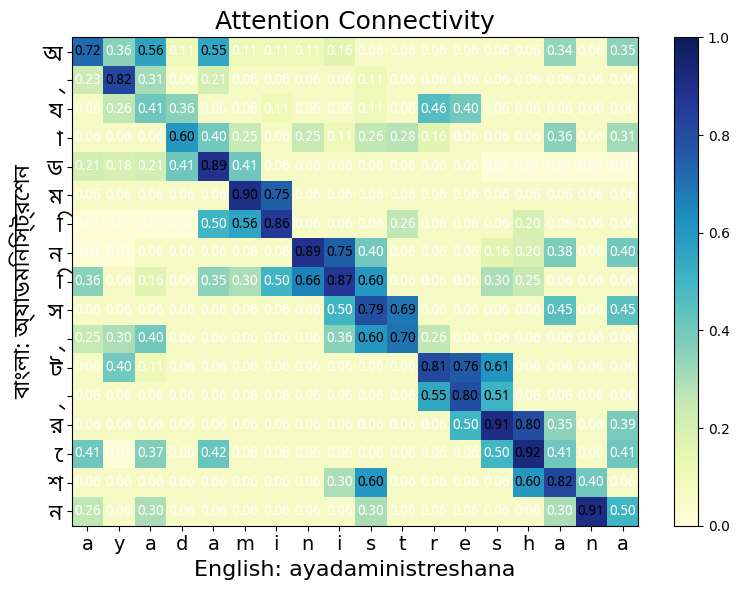

In [ ]:
import pandas as pd
import numpy as np
import torch.utils as utils
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import wandb
from matplotlib.colors import Normalize

from LoadDataset_Test import DatasetLoad
from PrepareVocabulary_Final import PrepareVocabulary
from WordEmbeddings_Create import WordEmbeddings
from ModelTrainDriver_Framework import Model
from AttentionWeightsFetch import plotAttn  # utility to extract attention weights

def main():
    '''load dataset'''
    lang = "bn"
    d = DatasetLoad()
    root = "/kaggle/input/dataset/Dakshina/bn/lexicons"
    d.loadDataset(root, lang)
    d.loadTestDataset(root, lang)

    '''build the vocabulary'''
    vocabulary = PrepareVocabulary()
    vocabulary.createVocabulary(d.train_dataset)

    '''create embeddings for train, val, test'''
    embeddingTrain = WordEmbeddings()
    embeddingTrain.createWordEmbeddings(d.train_dataset, vocabulary)

    embeddingVal = WordEmbeddings()
    embeddingVal.createWordEmbeddings(d.val_dataset, vocabulary)

    embeddingTest = WordEmbeddings()
    embeddingTest.createWordEmbeddings(d.test_dataset, vocabulary)

    '''wrapoing the embeddings in DataLoaders'''
    train_dataset = utils.data.TensorDataset(
        embeddingTrain.englishEmbedding,
        embeddingTrain.bengaliEmbedding
    )
    train_loader = utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True
    )

    val_dataset = utils.data.TensorDataset(
        embeddingVal.englishEmbedding,
        embeddingVal.bengaliEmbedding
    )
    val_loader = utils.data.DataLoader(
        val_dataset,
        batch_size=64
    )

    '''instantiating the best attention model'''
    model_att = Model(
        vocabulary,
        train_loader,
        val_loader,
        test=1,
        attention=1
    )
    model_att.createModelFramework(
        modelType="GRU",
        embeddingSize=16,
        neruonsInFC=128,
        layersInEncoder=3,
        layersInDecoder=1,
        dropout=0.2,
        bidirectional="NO",
        learningRate=0.001,
        epochs=10,
        batchSize=64
    )
    model_att.framework.eval()

    csv_path = "/kaggle/input/seqtoseqcsv/AttentionVsSeq2Seq.csv"
    df = pd.read_csv(csv_path)
    correct_df = df[df['Original'] == df['Attention']].copy()
    if correct_df.empty:
        raise RuntimeError("No exact matches in the CSV file")
    correct_df['eng_len'] = correct_df['English'].str.len()

    ''' simply pick one random correct prediction'''
    row = correct_df.sample(n=1).iloc[0]
    eng_word = row['English']
    beng_word = row['Attention']    
    print(f"\nPicked the word → English: '{eng_word}' | Predicted Bengali: '{beng_word}'\n")

    '''extract the true attention matrix'''
    attn_matrix = plotAttn(
        model_att.framework,
        [eng_word],
        [beng_word],
        vocabulary
    )    

    '''creating the heatmap'''
    font_path = '/kaggle/input/bengalifont/BengaliFont.ttf'
    prop = fm.FontProperties(fname=font_path)

    baseline = 0.01 * np.max(attn_matrix)
    enhanced = np.clip(attn_matrix + baseline, 0.0, 1.0)

    plt.figure(figsize=(8, 6))
    plt.imshow(enhanced,aspect='auto',cmap='YlGnBu',norm=Normalize(vmin=0.0, vmax=1.0))
    cbar = plt.colorbar()
    cbar.set_label('', fontsize=12)

    plt.xticks(np.arange(len(eng_word)), list(eng_word), fontsize=14)
    plt.yticks(np.arange(len(beng_word)), list(beng_word),
               fontproperties=prop, fontsize=16)
    plt.xlabel(f"English: {eng_word}", fontsize=16)
    plt.ylabel(f"বাংলা: {beng_word}", fontproperties=prop, fontsize=16)
    plt.title("Attention Connectivity", fontsize=18)

    for i in range(enhanced.shape[0]):
        for j in range(enhanced.shape[1]):
            val = enhanced[i, j]
            color = 'white' if val < 0.5 else 'black'
            plt.text(j, i, f"{val:.2f}",
                     ha='center', va='center',
                     color=color, fontproperties=prop, fontsize=10)

    plt.grid(which='minor', linestyle='-', linewidth=0.5, color='gray')
    plt.tight_layout()
    fig = plt.gcf()
    plt.show()

    '''Wandb logging'''
    wandb.login()
    run = wandb.init(
        project="Debasmita-DA6401-Assignment-3", 
        name="Question6_Visualisation"
    )
    run.log({"Attention_Matrix": wandb.Image(fig)})
    run.finish()

if __name__ == '__main__':
    main()

In [ ]:
# train.py file below

In [36]:
%%writefile train_arguments.py
import argparse

'''
  Parameters:
    None
  Returns :
    A parser object
  Function:
    Does command line argument parsing and returns the arguments passed
'''
def arguments():
    commandLineArgument = argparse.ArgumentParser(description='Model Parameters')
    commandLineArgument.add_argument('-wp','--wandb_project',help="Project name used to track experiments in Weights & Biases dashboard")
    commandLineArgument.add_argument('-we','--wandb_entity',help="Wandb Entity used to track experiments in the Weights & Biases dashboard")
    commandLineArgument.add_argument('-r','--root',help="Absolute path of the dataset")
    commandLineArgument.add_argument('-e','--epochs',type=int,help="Number of epochs to train neural network")
    commandLineArgument.add_argument('-b','--batch',type=int,help="Batch size to divide the dataset")
    commandLineArgument.add_argument('-n','--neurons',type=int,help="Number of neurons in the fully connected layer")
    commandLineArgument.add_argument('-d','--dropout',type=float,help="Percentage of dropout in the network")
    commandLineArgument.add_argument('-em','--embedding',type=int,help="Size of the embedding layer")
    commandLineArgument.add_argument('-enc','--encoder',type=int,help="Number of layers in the encoder")
    commandLineArgument.add_argument('-dec','--decoder',type=int,help="Number of layers in the decoder")
    commandLineArgument.add_argument('-c','--cell',help="Type of cell")
    commandLineArgument.add_argument('-bid','--bidir',help="choices: [YES,NO]")
    commandLineArgument.add_argument('-t','--test',type=int,help="choices: [0,1]")
    commandLineArgument.add_argument('-att','--attention',type=int,help="choices: [0,1]")
    commandLineArgument.add_argument('-ht','--heat',type=int,help="choices: [0,1]")
    commandLineArgument.add_argument('-f','--font',help="Font of the language chosen to generate the heatmap")

    return commandLineArgument.parse_args()

Writing train_arguments.py


In [ ]:
import wandb
import warnings
warnings.filterwarnings("ignore")
import argparse
from LoadDataset_Test import DatasetLoad
from PrepareVocabulary_Final import PrepareVocabulary
from WordEmbeddings_Create import WordEmbeddings
from ModelTrainDriver_Framework import Model
import ModelForTestAttention_Run
import ModelForTest_Run
import Heatmap_Run
import Utilities_Tensor
import Utilities_Sequence
import train_arguments
import itertools
import torch.utils as utils
import random
import os

'''login to wandb to generate plot'''
wandb.login()

'''main driver function'''
def main():
    '''default values of each of the hyperparameter. it is set according to the config of my best model'''
    project_name = 'Debasmita-DA6401-Assignment-3'
    entity_name = 'cs24m015-indian-institute-of-technology-madras' 
    modelType = "GRU"
    embeddingSize = 16
    neruonsInFC = 128
    layersInEncoder = 3
    layersInDecoder = 1
    bidirectional = "NO"
    learningRate = 0.001
    epochs = 10
    batchSize = 64
    dropoutProb = 0.2
    test = 1
    root = '/kaggle/input/dataset/Dakshina/bn/lexicons'
    attention = 1
    heatmap = 1
    fontName = '/kaggle/input/bengalifont/BengaliFont.ttf'

    '''call to argument function to get the arguments'''
    argumentsPassed = train_arguments.arguments()

    '''checking if a particular argument is passed through command line or not and updating the values accordingly'''
    if argumentsPassed.wandb_project is not None:
        project_name = argumentsPassed.wandb_project
    if argumentsPassed.wandb_entity is not None:
        entity_name = argumentsPassed.wandb_entity
    if argumentsPassed.cell is not None:
        modelType = argumentsPassed.cell
    if argumentsPassed.embedding is not None:
        embeddingSize = argumentsPassed.embedding
    if argumentsPassed.neurons is not None:
        neruonsInFC = argumentsPassed.neurons
    if argumentsPassed.encoder is not None:
        layersInEncoder = argumentsPassed.encoder
    if argumentsPassed.decoder is not None:
        layersInDecoder = argumentsPassed.decoder
    if argumentsPassed.bidir is not None:
        bidirectional = argumentsPassed.bidir
    if argumentsPassed.epochs is not None:
        epochs = argumentsPassed.epochs
    if argumentsPassed.batch is not None:
        batchSize = argumentsPassed.batch
    if argumentsPassed.dropout is not None:
        dropoutProb = argumentsPassed.dropout
    if argumentsPassed.test is not None:
        test = argumentsPassed.test
    if argumentsPassed.root is not None:
        root = argumentsPassed.root
    if argumentsPassed.attention is not None:
        attention = argumentsPassed.attention
    if argumentsPassed.heat is not None:
        heatmap = argumentsPassed.heat
    if argumentsPassed.font is not None:
        fontName = argumentsPassed.font

    '''initializing to the project'''
    wandb.init(project=project_name, entity=entity_name)

    '''calling the functions with the parameters'''
    if attention == 0:
        run = f"EP_{epochs}_CELL_{modelType}_EMB_{embeddingSize}_ENC_{layersInEncoder}_DEC_{layersInDecoder}_FC_{neruonsInFC}_DRP_{dropoutProb}_BS_{batchSize}_BIDIREC_{bidirectional}"
    else:
        run = f"ATT_YES_EP_{epochs}_CELL_{modelType}_EMB_{embeddingSize}_ENC_{layersInEncoder}_DEC_{layersInDecoder}_FC_{neruonsInFC}_DRP_{dropoutProb}_BS_{batchSize}_BIDIREC_{bidirectional}"
    print(f"run name = {run}")
    wandb.run.name = run

    Train.runTrain(root, epochs, batchSize, test, attention, heatmap, modelType, embeddingSize, layersInEncoder, layersInDecoder, neruonsInFC, bidirectional, dropoutProb, learningRate, fontName)
    wandb.finish()


class Train:
    def runTrain(
        root, epochs, batchSize, test, attention, heatmap,
        modelType, embeddingSize, layersInEncoder, layersInDecoder,
        neruonsInFC, bidirectional, dropoutProb, learningRate, fontName
    ):
        '''loads dataset'''
        lang = os.path.basename(os.path.dirname(root))
        d = DatasetLoad()
        d.loadDataset(root, lang)
        d.loadTestDataset(root, lang)
        
        '''creates vocabulary from the dataset'''
        vocabulary = PrepareVocabulary()
        vocabulary.createVocabulary(d.train_dataset)

        '''create embeddings of words for train, validation and test dataset'''
        embeddingTrain = WordEmbeddings()
        embeddingTrain.createWordEmbeddings(d.train_dataset, vocabulary)

        embeddingVal = WordEmbeddings()
        embeddingVal.createWordEmbeddings(d.val_dataset, vocabulary)

        embeddingTest = WordEmbeddings()
        embeddingTest.createWordEmbeddings(d.test_dataset, vocabulary)

        '''create the dataloaders'''
        trainEmbeddedDataset = utils.data.TensorDataset(
            embeddingTrain.englishEmbedding,
            embeddingTrain.bengaliEmbedding
        )
        trainEmbeddedDataLoader = utils.data.DataLoader(
            trainEmbeddedDataset, batch_size=64, shuffle=True
        )

        valEmbeddedDataset = utils.data.TensorDataset(
            embeddingVal.englishEmbedding,
            embeddingVal.bengaliEmbedding
        )
        valEmbeddedDataLoader = utils.data.DataLoader(
            valEmbeddedDataset, batch_size=64
        )

        testEmbeddedDataset = utils.data.TensorDataset(
            embeddingTest.englishEmbedding,
            embeddingTest.bengaliEmbedding
        )
        testEmbeddedDataset = utils.data.DataLoader(
            testEmbeddedDataset, batch_size=64
        )

        '''create an object of the encoder-decoder architecture with the best configuration for attention based model'''
        myModel = Model(
            vocabulary, trainEmbeddedDataLoader, valEmbeddedDataLoader,
            test=test, attention=attention, trainPy=1
        )
        framework = myModel.createModelFramework(
            modelType=modelType,
            embeddingSize=embeddingSize,
            neruonsInFC=neruonsInFC,
            layersInEncoder=layersInEncoder,
            layersInDecoder=layersInDecoder,
            dropout=dropoutProb,
            bidirectional=bidirectional,
            learningRate=learningRate,
            epochs=epochs,
            batchSize=batchSize
        )

        '''if prompted then do testing'''
        if test == 1:
            if attention == 1:
                '''call the function which calculates the accuracy and loss'''
                paramList = [
                    framework, testEmbeddedDataset, d.test_dataframe,
                    64, vocabulary.paddingIndex,
                    vocabulary.endOfSequenceIndex,
                    vocabulary.indexToCharDictForBengali
                ]
                ModelForTestAttention_Run.RunTestOnBestModel.testAndGivePredictions(
                    paramList, trainPy=1
                )

                '''if required then plot the heatmap'''
                if heatmap == 1:
                    englishLength = embeddingTest.englishEmbedding.size(1)
                    bengaliLength = embeddingTest.bengaliEmbedding.size(1)

                    requiredIndices = random.sample(range(4097), 9)

                    '''create zero tensros for stroing the words'''
                    englishWords = Utilities_Tensor.getLongZeroTensor(
                        len(requiredIndices), englishLength
                    )
                    bengaliWords = Utilities_Tensor.getLongZeroTensor(
                        len(requiredIndices), bengaliLength
                    )

                    '''store 9 source and their corresponding target words to create heatmap'''
                    for heatmapIndex, position in enumerate(requiredIndices):
                        batchPosition = Utilities_Sequence.getBatchFloorValue(position, 64)
                        datasetPosition = position - batchPosition * 64
                        data = next(
                            itertools.islice(testEmbeddedDataset, batchPosition, None)
                        )
                        englishWord, bengaliWord = data[0][datasetPosition], data[1][datasetPosition]
                        englishWords[heatmapIndex] = englishWord
                        bengaliWords[heatmapIndex] = bengaliWord
                        heatmapIndex += 1
                    Heatmap_Run.plotAttn(
                        framework, englishWords, bengaliWords,
                        vocabulary, trainPy=1, fontName=fontName
                    )
            else:
                '''call the function which calculates the accuracy and loss'''
                paramList = [
                    framework, testEmbeddedDataset, d.test_dataframe,
                    64, vocabulary.paddingIndex,
                    vocabulary.endOfSequenceIndex,
                    vocabulary.indexToCharDictForBengali
                ]
                ModelForTest_Run.RunTestOnBestModel.testAndGivePredictions(paramList, trainPy=1)



if __name__ == '__main__':
    main()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cs24m015 (cs24m015-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


run name = ATT_YES_EP_10_CELL_GRU_EMB_16_ENC_3_DEC_1_FC_128_DRP_0.2_BS_64_BIDIREC_NO

Epoch : 1
Training Accuracy : 0.16337533829499323
Validation Accuracy : 0.15150862068965518
Training Loss : 0.607886224864139
Validation Loss : 0.7484891700333562

Epoch : 2
Training Accuracy : 0.28256089309878213
Validation Accuracy : 0.22650862068965516
Training Loss : 0.4812666651602527
Validation Loss : 0.6547144366749402

Epoch : 3
Training Accuracy : 0.3339605886332882
Validation Accuracy : 0.2540948275862069
Training Loss : 0.43995033160194813
Validation Loss : 0.6326976554147128


KeyboardInterrupt: 